# 1 + 1 = 1 or Record Deduplication with Python
Flávio Juvenal  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  
Partner at <a href="http://www.vinta.com.br?dedupe-slides=1"><img class="vinta_logo" style="display: inline-block; margin-left: 0;" src="vinta.png" width=300></a>

<div style="font-size: 2em; text-weight: bold">
Slides available at: <a href="http://bit.ly/pybay-dupe">bit.ly/pybay-dupe</a>
</div>

## Introduction

Real world data is inputted by people and usually it's:
* Not reviewed
* Not linked with related data
* Not properly normalized by the input system
* Or simply it's incorrectly inputted because people make mistakes: typos, mishearing, miscalculation, misinterpretation, etc.

This causes the following problems on data:
* lack of unique identifiers (making difficult detect duplicates in a dataset or to link with other datasets)
* duplications (e.g. multiple records refer to a single person)
* inconsistencies (e.g. a person appears with multiple addresses)
* bad formatting (e.g. birth dates appear with multiple formats like DD/MM/YY and YYYY-MM-DD)

All of that affects the ability to properly **extract knowledge** from one or more datasets.

The solution is to perform **[Record Linkage](https://en.wikipedia.org/wiki/Record_linkage)**. It works by joining records in a **fuzzy way** using data like names, addresses, phone numbers, dates, etc.

The term Record Linkage is most used when the linkage is applied to multiple datasets, like joining a Restaurant Food Inspection dataset with a Employee Wage dataset. In fact, [someone did just that](https://www.enigma.com/blog/on-wages-and-hygiene-surfacing-bad-management-in-public-data).

Record Linkage is also known as Data Matching, Entity Resolution, and [other names](https://en.wikipedia.org/wiki/Record_linkage#Naming_conventions).

What we'll discuss here is a specific application of Record Linkage, called **Deduplication**, which is applying Record Linkage on a single dataset against itself to **find which records are duplicates**. Here's a very simple example:

In [1]:
import warnings; warnings.simplefilter('ignore')
import logging; logging.disable(level=logging.INFO)

In [2]:
import pandas as pd

data = [
    ("Chin's","3200 Las Vegas Boulevard","New York"),
    ("Chin Bistro","3200 Las Vegas Blvd.","New York"),
    ("Bistro","3400 Las Vegas Blvd.","New York City"),
    ("Bistro","3400 Las Vegas B.","NYC"),
]

df = pd.DataFrame(data, columns=['restaurant', 'address', 'city'])

In [3]:
df

,restaurant,address,city
0,Chin's,3200 Las Vegas Boulevard,New York
1,Chin Bistro,3200 Las Vegas Blvd.,New York
2,Bistro,3400 Las Vegas Blvd.,New York City
3,Bistro,3400 Las Vegas B.,NYC


A good deduplication on the data above would find that:
  - `(0, 1)` are duplicates
  - `(2, 3)` are duplicates 
  - but `(0, 1)` and `(2, 3)` are different, desipite being similar

## Process

The process for deduplicating a dataset usually is:
  0. Preprocessing
    * input: dataset 
    * output: cleaned dataset
  1. Indexing
    * output: pairs to compare
  2. Comparison
    * output: comparison vectors
  3. Classification
    * output: matching/nonmatching pairs
  4. Clustering 
    * output: unique record clusters
    
Let's explore each of those steps!

## 0/4 - Preprocessing
Without unique identifiers, we usually have to **clean** the following types of data:
- Names
- Addresses
- Phone Numbers
- Dates

### Cleaning names (companies or people)

Let's use string functions and regexes to **normalize** names and remove undesired variations:

In [4]:
import numpy as np
import re
import pprint


company_names = company_names_dirty = [
    'APPLE COMPUTER INC',
    'APPLE COMPUTER, INC.',
    'APPLE INC',
    'Apple Computer',
    'Apple Computer Co.',
    'Apple Computer Company',
    'Apple Computer Inc',
    'Apple Computer Incorporated',
    'Apple Computer, Inc.',
    'Apple Inc',
    'Apple Inc.',
    'Apple, Inc.'
]

In [5]:
print("Lower case:")
company_names = [c.lower() for c in company_names]
pprint.pprint(company_names)

Lower case:
['apple computer inc',
 'apple computer, inc.',
 'apple inc',
 'apple computer',
 'apple computer co.',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer, inc.',
 'apple inc',
 'apple inc.',
 'apple, inc.']


In [6]:
print("Remove irrelevant separators:")
irrelevant_regex = re.compile(r'[^a-z0-9\s]')
company_names = [irrelevant_regex.sub(' ', c) for c in company_names]
pprint.pprint(company_names)

Remove irrelevant separators:
['apple computer inc',
 'apple computer  inc ',
 'apple inc',
 'apple computer',
 'apple computer co ',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer  inc ',
 'apple inc',
 'apple inc ',
 'apple  inc ']


In [7]:
print("Remove multi-spaces:")
multispace_regex = re.compile(r'\s\s+')
company_names = [multispace_regex.sub(' ', c).strip() for c in company_names]
pprint.pprint(company_names)

Remove multi-spaces:
['apple computer inc',
 'apple computer inc',
 'apple inc',
 'apple computer',
 'apple computer co',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer inc',
 'apple inc',
 'apple inc',
 'apple inc']


In [8]:
print("Remove stopwords:")
business_stopwords = {  # suppose we got this from somewhere
    'computer',
    'co',
    'company',
    'corp',
    'corporation',
    'inc',
    'incorporated',
    'llc',
    #...
}

company_names = [
    ' '.join([c_part for c_part in c.split() if c_part not in business_stopwords])
    for c in company_names
]
pprint.pprint(company_names)

Remove stopwords:
['apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple']


We can also use the natural language processing library [**probablepeople**](https://github.com/datamade/probablepeople) to **parse company names** and extract just the parts we want (or break into parts and match by part on the comparison step later):

In [9]:
import probablepeople as pp

pp.parse("Apple Computer Incorporated")

[('Apple', 'CorporationName'),
 ('Computer', 'CorporationName'),
 ('Incorporated', 'CorporationLegalType')]

In [10]:
company_names_alternative_1 = [
    [
        parsed_value
        for parsed_value, parsed_type
        in pp.parse(c)
        if parsed_type == 'CorporationName'
    ]
    for c in company_names_dirty
]
pprint.pprint(company_names_alternative_1)

[['APPLE', 'COMPUTER'],
 ['APPLE', 'COMPUTER,'],
 ['APPLE'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer,'],
 ['Apple'],
 ['Apple'],
 ['Apple,']]


probablepeople, as the name suggests, can parse **people** names too:

In [11]:
pp.parse('Mr. Guido van Rossum')

[('Mr.', 'PrefixMarital'),
 ('Guido', 'GivenName'),
 ('van', 'Surname'),
 ('Rossum', 'Surname')]

But performance isn't great from non-English names. So you can try [**nameparser**](https://github.com/derek73/python-nameparser/), which is **not probabilistic**:

In [12]:
from nameparser import HumanName
from IPython.display import display

display(pp.parse('Flávio Juvenal da Silva Jr'))
display(HumanName('Flávio Juvenal da Silva Jr'))

[('Flávio', 'CorporationName'),
 ('Juvenal', 'CorporationName'),
 ('da', 'CorporationName'),
 ('Silva', 'CorporationName'),
 ('Jr', 'CorporationName')]

<HumanName : [
	title: '' 
	first: 'Flávio' 
	middle: 'Juvenal' 
	last: 'da Silva' 
	suffix: 'Jr'
	nickname: ''
]>

If it's useful to **ignore accents**, try [**unidecode**](https://github.com/avian2/unidecode):

In [13]:
import unidecode

print("ASCII transliteration:")
brazilian_name = "Flávio"
print(brazilian_name, "->")
print(unidecode.unidecode(brazilian_name))

ASCII transliteration:
Flávio ->
Flavio


It's important to consider how the data values were inputted. If the value was inputted by someone while hearing from someone else, try **phonetic encoding** with [**doublemetaphone**](https://github.com/dedupeio/doublemetaphone) to normalize words that sound similar:

In [14]:
from doublemetaphone import doublemetaphone

print(doublemetaphone('Andrew'))
print(doublemetaphone('André'))

('ANTR', 'ANTRF')
('ANTR', 'ANTR')


If data was obtained via Optical Character Recognition (OCR), techniques exist to correct common misspellings that OCRs make (like C to L, S to 5, q to g, etc). See Christen, page 47 [2].

### Cleaning addresses

Geocoding street addresses, i.e., converting them to **latitude/longitude** is very useful for matching, because geocoders usually clean irrelevant address variations. Also, having lat/lng enables the calculation of geometric distances between addresses.

In [15]:
import requests
import geocoder

full_addresses = [
    "2066 Crist Drive, 94024, Los Altos, CALIFORNIA, US",
    "2066 Crist Dr, 94024, LOS ALTOS, CALIFORNIA, US",
    "20863 Stevens Creek Blvd., Suite 300, 95015, CUPERTINO, CALIFORNIA, US",
    "20863 STEVENS CREEK BLVD STE 330, 95014, Lupertino, CALIFORNIA, US",
    "10260 Bandley Drive, 95014, Cupertino, CALIFORNIA, US",
    "10260 Bandley Dr., 95014, Cupertino, CALIFORNIA, US",
    "20525 MARIANI AVENUE, 95014, CUPERTINO, CALIFORNIA, US",
    "20525 Mariani Ave, 95014, CUPERTINO, CALIFORNIA, US",
    "1 Infinite Loop, 95014, Cupertino, CALIFORNIA, US",
    "One Infinite Loop,, 95014, Cupertino, CALIFORNIA, US",
    "One Apple Park Way, 95014, Cupertino, CALIFORNIA, US",
    "1 Apple Park Way, 95014, Cupertino, CALIFORNIA, US",
]

full_addresses_latlng = []
with requests.Session() as session:
    for a in full_addresses:
        a_geocoded = geocoder.google(a, session=session)
        full_addresses_latlng.append(a_geocoded.latlng)

address_latlng = list(zip(full_addresses, full_addresses_latlng))

In [16]:
pprint.pprint((address_latlng[2], address_latlng[3]))
print()

(('20863 Stevens Creek Blvd., Suite 300, 95015, CUPERTINO, CALIFORNIA, US',
  [37.3241563, -122.0387297]),
 ('20863 STEVENS CREEK BLVD STE 330, 95014, Lupertino, CALIFORNIA, US',
  [37.3241563, -122.0387297]))



Google geocoder is able to:
- Ignore lower/upper case difference
- Ignore the difference between Suite 300 vs 330 (building entrance may be the same)
- Consider 'Lupertino' as 'Cupertino'
- Expand abbreviations, like 'STE' vs 'Suite'

In [17]:
pprint.pprint((address_latlng[8], address_latlng[9]))

(('1 Infinite Loop, 95014, Cupertino, CALIFORNIA, US',
  [37.3324975, -122.0289785]),
 ('One Infinite Loop,, 95014, Cupertino, CALIFORNIA, US',
  [37.33182, -122.03118]))


However, it gets slighly different addresses on the case of '1' vs 'One'.

Note geocoding from web APIs is slow and has quota limits! Alternatively, you can build **your own geocoder** with:
- https://github.com/openstreetmap/Nominatim
- https://github.com/pelias/pelias
- https://github.com/komoot/photon
- https://postgis.net/docs/Extras.html
- https://github.com/openvenues/lieu

If geocoding is inviable, we can use the library [**pypostal**](https://github.com/openvenues/pypostal) to **normalize** addresses:

In [18]:
from postal.expand import expand_address

print(full_addresses[8])
pprint.pprint(expand_address(full_addresses[8]))
print()
print(full_addresses[9])
pprint.pprint(expand_address(full_addresses[9]))

1 Infinite Loop, 95014, Cupertino, CALIFORNIA, US
['1 infinite loop 95014 cupertino california us']

One Infinite Loop,, 95014, Cupertino, CALIFORNIA, US
['1 infinite loop 95014 cupertino california us']


In [19]:
print(full_addresses[2])
pprint.pprint(expand_address(full_addresses[2]))
print()
print(full_addresses[3])
pprint.pprint(expand_address(full_addresses[3]))

20863 Stevens Creek Blvd., Suite 300, 95015, CUPERTINO, CALIFORNIA, US
['20863 stevens creek boulevard suite 300 95015 cupertino california us']

20863 STEVENS CREEK BLVD STE 330, 95014, Lupertino, CALIFORNIA, US
['20863 stevens creek boulevard suite 330 95014 lupertino california us',
 '20863 stevens creek boulevard sainte 330 95014 lupertino california us']


From [DataMade](https://datamade.us/), the creators of probablepeople, there's a [**usaddress**](https://github.com/datamade/usaddress) **parser**:

In [20]:
import usaddress

print(full_addresses[0])
pprint.pprint(usaddress.parse(full_addresses[0]))
print()
print(full_addresses[1])
pprint.pprint(usaddress.parse(full_addresses[1]))

2066 Crist Drive, 94024, Los Altos, CALIFORNIA, US
[('2066', 'AddressNumber'),
 ('Crist', 'StreetName'),
 ('Drive,', 'StreetNamePostType'),
 ('94024,', 'SubaddressIdentifier'),
 ('Los', 'PlaceName'),
 ('Altos,', 'PlaceName'),
 ('CALIFORNIA,', 'PlaceName'),
 ('US', 'StateName')]

2066 Crist Dr, 94024, LOS ALTOS, CALIFORNIA, US
[('2066', 'AddressNumber'),
 ('Crist', 'StreetName'),
 ('Dr,', 'StreetNamePostType'),
 ('94024,', 'ZipCode'),
 ('LOS', 'PlaceName'),
 ('ALTOS,', 'PlaceName'),
 ('CALIFORNIA,', 'PlaceName'),
 ('US', 'StateName')]


### Cleaning phone numbers

[**phonenumbers**](https://github.com/daviddrysdale/python-phonenumbers) library can **normalize** phone numbers from many countries:

In [21]:
import phonenumbers

print("Phone number normalization:")
phone = "(541) 555-3010"
print(phone, '->')
print(
    phonenumbers.format_number(
        phonenumbers.parse(phone, 'US'),
        phonenumbers.PhoneNumberFormat.E164)
)

Phone number normalization:
(541) 555-3010 ->
+15415553010


### Cleaning dates

[**dateparser**](https://github.com/scrapinghub/dateparser) library can **guess** date formats and parse them as datetime objects. It can even guess DD/MM or MM/DD by the language:

In [22]:
import dateparser

print(dateparser.parse("at 10/1/2018 10am"))
print(dateparser.parse("às 10/1/2018 10:00"))
pprint.pprint(dateparser.DateDataParser().get_date_data("às 10/1/2018 10:00"))

2018-10-01 10:00:00
2018-01-10 10:00:00
{'date_obj': datetime.datetime(2018, 1, 10, 10, 0),
 'locale': 'pt',
 'period': 'day'}


Check also [**dateutil parser**](https://dateutil.readthedocs.io/en/stable/parser.html#dateutil.parser.parse) with `fuzzy=True`.

### Cleaning a real dataset

Now we know the tools, let's **grab a dataset to preprocess and go on the other deduplication steps**. Our dataset is based* on the [Restaurant](https://www.cs.utexas.edu/users/ml/riddle/data.html) dataset, a well known dataset used by researchers. It contains 881 restaurant records and contains 150 duplicates.

\* We've introduced some changes that you can check by doing a `diff restaurant.original.csv restaurant.csv`

In [23]:
df_with_truth = pd.read_csv('restaurant.csv', skip_blank_lines=True)
df_with_truth.head(9)

,name,addr,city,phone,type,cluster
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0
2,arnie morton,435 s. la cienega boulevard,los angeles,310-246-1501,steakhouses,0
3,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1
4,art's deli,12224 ventura blvd.,studio city,818-762-1221,delis,1
5,art's deli,12224 ventura blvd.,los angeles,818-762-1221,delis,1
6,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2
7,bel-air hotel,701 stone canyon rd.,bel air,310-472-1211,californian,2
8,bel-air,701 stone canyon road,bel air,(310) 472-1211,american,2


The dataset comes with the true matches indicated by the 'cluster' column. We'll remove it. We'll also remove the 'phone' to makes things more difficult:

In [24]:
df = df_with_truth.drop(columns=['cluster', 'phone'])
df.head(9)

,name,addr,city,type
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,american
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,steakhouses
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses
3,art's delicatessen,12224 ventura blvd.,studio city,american
4,art's deli,12224 ventura blvd.,studio city,delis
5,art's deli,12224 ventura blvd.,los angeles,delis
6,hotel bel-air,701 stone canyon rd.,bel air,californian
7,bel-air hotel,701 stone canyon rd.,bel air,californian
8,bel-air,701 stone canyon road,bel air,american


By running `info` method, we assert our dataset is quite clean, missing only 1 value of 'type'. We'll ignore it. Note that on other datasets you might need to do more **profiling** to know what to fix. Check Mull's talk [1].

In [25]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 4 columns):
name    881 non-null object
addr    881 non-null object
city    881 non-null object
type    880 non-null object
dtypes: object(4)
memory usage: 27.6+ KB


Now we'll clean the column values! Cleaning **name**:

In [26]:
def assign_no_symbols_name(df):
    return df.assign(
        name=df['name'].astype(str)
             .str.replace(irrelevant_regex, ' ')
             .str.replace(multispace_regex, ' '))

df = assign_no_symbols_name(df)
df.head(9)

,name,addr,city,type
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,american
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,steakhouses
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses
3,art s delicatessen,12224 ventura blvd.,studio city,american
4,art s deli,12224 ventura blvd.,studio city,delis
5,art s deli,12224 ventura blvd.,los angeles,delis
6,hotel bel air,701 stone canyon rd.,bel air,californian
7,bel air hotel,701 stone canyon rd.,bel air,californian
8,bel air,701 stone canyon road,bel air,american


In [27]:
from collections import Counter

possible_stopwords = Counter(" ".join(df["name"]).split()).most_common(20)
pprint.pprint(possible_stopwords)

[('s', 184),
 ('cafe', 81),
 ('the', 39),
 ('grill', 32),
 ('restaurant', 26),
 ('la', 24),
 ('le', 20),
 ('house', 20),
 ('bar', 19),
 ('of', 15),
 ('bistro', 13),
 ('room', 11),
 ('kitchen', 10),
 ('deli', 9),
 ('club', 9),
 ('and', 9),
 ('ritz', 9),
 ('carlton', 9),
 ('on', 8),
 ('buckhead', 8)]


In [28]:
def assign_cleaned_name(df):
    restaurant_stopwords = {
        's',
        'the',
        'la',
        'le',
        'of',
        'and',
        'on',
        'l',
    }
    restaurant_stopwords_regex = r'\b(?:{})\b'.format(
        '|'.join(restaurant_stopwords))
    return df.assign(
        name=df['name'].astype(str)
                       .str.replace(restaurant_stopwords_regex, '')
                       .str.replace(multispace_regex, ' ')
                       .str.strip())

df = assign_cleaned_name(df)
df.head(9)

,name,addr,city,type
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses
3,art delicatessen,12224 ventura blvd.,studio city,american
4,art deli,12224 ventura blvd.,studio city,delis
5,art deli,12224 ventura blvd.,los angeles,delis
6,hotel bel air,701 stone canyon rd.,bel air,californian
7,bel air hotel,701 stone canyon rd.,bel air,californian
8,bel air,701 stone canyon road,bel air,american


Geocoding **addr**:

In [29]:
all_addresses = df['addr'].astype(str).str.cat(
    df['city'].astype(str), sep=', ').values
unique_addresses = np.unique(all_addresses)
print(len(all_addresses), len(unique_addresses))

881 819


In [30]:
import os.path
import json

geocoding_filename = 'address_to_geocoding.json'

def geocode_addresses(address_to_geocoding):
    remaining_addresses = (
        set(unique_addresses) -
        set(k for k, v in address_to_geocoding.items() if v is not None))
    
    with requests.Session() as session:
        for i, address in enumerate(remaining_addresses):
            print(f"Geocoding {i + 1}/{len(remaining_addresses)}")
            geocode_result = geocoder.google(address, session=session)
            address_to_geocoding[address] = geocode_result.json

        with open(geocoding_filename, 'w') as f:
            json.dump(address_to_geocoding, f, indent=4)

if not os.path.exists(geocoding_filename):
    address_to_geocoding = {}
    geocode_addresses(address_to_geocoding)
else:
    with open(geocoding_filename) as f:
        address_to_geocoding = json.load(f)
    geocode_addresses(address_to_geocoding)
 
address_to_postal = {
    k: v['postal']
    for k, v in address_to_geocoding.items()
    if v is not None and 'postal' in v
}
address_to_latlng = {
    k: (v['lat'], v['lng'])
    for k, v in address_to_geocoding.items()
    if v is not None
}
print(f"Failed to get postal from {len(address_to_geocoding) - len(address_to_postal)}")
print(f"Failed to get latlng from {len(address_to_geocoding) - len(address_to_latlng)}")

Failed to get postal from 8
Failed to get latlng from 0


In [31]:
def assign_postal_lat_lng(df):
    addresses = df['addr'].astype(str).str.cat(df['city'].astype(str), sep=', ')
    addresses_to_postal = [address_to_postal.get(a) for a in addresses]
    addresses_to_lat = [address_to_latlng[a][0] if a in address_to_latlng else None for a in addresses]
    addresses_to_lng = [address_to_latlng[a][1] if a in address_to_latlng else None for a in addresses]

    return df.assign(postal=addresses_to_postal, lat=addresses_to_lat, lng=addresses_to_lng)

df = assign_postal_lat_lng(df)
df.head(6)

,name,addr,city,type,postal,lat,lng
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,90048,34.070609,-118.376722
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,90048,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,90048,34.070609,-118.376722
3,art delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469
4,art deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469
5,art deli,12224 ventura blvd.,los angeles,delis,91604,34.142966,-118.399469


Adding **addr_variations**:

In [32]:
def assign_addr_variations(df):
    return df.assign(
        addr_variations=df['addr'].astype(str).apply(
            lambda addr: frozenset(expand_address(addr))))

df = assign_addr_variations(df)
df.head(5)

,name,addr,city,type,postal,lat,lng,addr_variations
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,90048,34.070609,-118.376722,"(435 san louisiana cienega bulevar, 435 sur la..."
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,90048,34.070609,-118.376722,"(435 sur la cienega boulevard, 435 south lane ..."
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,90048,34.070609,-118.376722,"(435 south lane cienega boulevard, 435 san lan..."
3,art delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469,(12224 ventura boulevard)
4,art deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469,(12224 ventura boulevard)


Now, with a clean dataset, we can move to the next step.

## 1/4 - Indexing

To explain the following deduplication steps, we'll use the Python libary **recordlinkage**, aka **[Python Record Linkage Toolkit](http://recordlinkage.readthedocs.io/en/latest/ref-compare.html)**. We choose it because it doesn't abstract too much the details of the process, even though it has a simple API.

We have the cleaned records, we now need the pairs we want to compare to find matches.
To **produce the pairs**, we could do a "full" index, i.e., all records against all records:

In [33]:
import recordlinkage as rl

full_indexer = rl.Index()
full_indexer.full()
pairs = full_indexer.index(df)

print(f"Full index: {len(df)} records, {len(pairs)} pairs")

Full index: 881 records, 387640 pairs


The formula for the total number of pairs is:  
`len(df) * (len(df) - 1) / 2 == 387640`

<div><img style="display: block; margin: 0 auto;" src="full-indexing.png?" width=600></div>

The number of pairs grows too fast as the number of records grows: it **grows quadratically**.
That's why we need **indexing**. We need to produce only pairs that are good candidates of being duplicates.

Indexing is also called **blocking** because the straightforward way to index is to produce pairs that have **some column value in common**. By doing this, we produce blocks of record pairs and compare only those in the same block:

<div><img style="display: block; margin: 0 auto;" src="standard-blocking.png?" width=600></div>

Below we produce pairs that have **equal values for postal** code:

In [34]:
postal_indexer = rl.Index()
postal_indexer.block('postal')
postal_index_pairs = postal_indexer.index(df)

print(f"Postal index: {len(postal_index_pairs)} pairs")

Postal index: 6536 pairs


We could also prouce pairs by sorting the unique values of some column and, for each value, getting the records with **neighboring values**. The idea is to produce pairs with close values on some column, like `johnny` and `john` or  `2018-01-02` and `2018-01-05`. It looks like this:

<div><img style="display: block; margin: 0 auto;" src="sorted-neighbourhood.png?" width=600></div>

Below we produce pairs that have **neighboring values for name**:

In [35]:
name_indexer = rl.Index()
name_indexer.sortedneighbourhood('name', window=7)
name_index_pairs = name_indexer.index(df)

print(f"Name index: {len(name_index_pairs)} pairs")

Name index: 3132 pairs


Note that simply sorting values wouldn't be able to get `kamila` and `camila` as neighbors, as sorting is sensitive to the leading characters of strings. There are other ways to index that could handle that, check Christen, chapter 4 [2].

To produce more pairs without introducing redundant pairs, we should **union** different indexes:

In [36]:
pairs = postal_index_pairs.union(name_index_pairs)

print(f"Postal or name index: {len(pairs)} pairs")

Postal or name index: 9465 pairs


We now have **which pairs** we want to run comparisons on!

## 2/4 - Comparison

Now we want to run comparisons on the indexed pairs to produce **a comparison vector for each pair**. A comparison vector represents the similarity between 2 records by holding similarity values between 0 to 1 for each column.

In [37]:
pd.DataFrame([[1.0, 0.75, 0.0, 0.25, 0.0]],
             columns=['name', 'addr', 'type', 'latlng', 'addr_variations'],
             index=pd.MultiIndex.from_arrays([[100], [200]]))

,,name,addr,type,latlng,addr_variations
100,200,1.0,0.75,0.0,0.25,0.0


For example, the comparison vector above means the pair of records `(100, 200)` has:
- Equal `name`s
- Similar `addr`s
- Completely different `type`s
- Some distance on `latlng`s
- No agreement on `addr_variations`

To compute the comparison vectors for all indexed pairs, we define a **similarity function** for each column:

In [38]:
vectorized_intersection = np.vectorize(
    lambda x, y: float(bool(x.intersection(y))))

def compare_addr_variations(a1, a2):
    return vectorized_intersection(a1, a2)

comp = rl.Compare()
comp.string('name', 'name', method='jarowinkler', label='name')
comp.string('addr', 'addr', method='jarowinkler', label='addr')
comp.string('city', 'city', method='jarowinkler', label='city')
comp.string('type', 'type', method='jarowinkler', label='type')
comp.geo('lat', 'lng', 'lat', 'lng', method='exp', scale=0.5, label='latlng')
comp.compare_vectorized(compare_addr_variations,
                        'addr_variations', 'addr_variations',
                        label='addr_variations');

There are many similarity functions we could use for **strings**. For example:
- `jarowinkler` gives priority to the begining of the string
- `levenshtein` cares more about the order
- `lcs` cares less about the order

In [39]:
from recordlinkage.algorithms.string import (
    jarowinkler_similarity as jarowinkler,
    levenshtein_similarity as levenshtein,
    longest_common_substring_similarity as lcs)

for s1, s2 in [["arnie morton", "arnie morton s of chicago"],
               ["the palm", "palm the"]]:
    print(f'jarowinkler("{s1}", "{s2}") ==',
          jarowinkler([s1], [s2])[0])
    print(f'levenshtein("{s1}", "{s2}") ==',
          levenshtein([s1], [s2])[0])
    print(f'lcs("{s1}", "{s2}") ==',
          lcs([s1], [s2])[0])
    print()

jarowinkler("arnie morton", "arnie morton s of chicago") == 0.896
levenshtein("arnie morton", "arnie morton s of chicago") == 0.48
lcs("arnie morton", "arnie morton s of chicago") == 0.6486486486486487

jarowinkler("the palm", "palm the") == 0.4166666666666667
levenshtein("the palm", "palm the") == 0.0
lcs("the palm", "palm the") == 0.875



For more details on the different similarity functions you can use, check Christen, chapter 5 [2]. Also, check the similarity functions [implemented on recordlikage library](http://recordlinkage.readthedocs.io/en/latest/ref-compare.html).

Now we'll compute the similarities between the columns of the pairs to get the **comparison vectors**:

In [40]:
comparison_vectors = comp.compute(pairs, df)
comparison_vectors.head(5)

name      addr     city      type   latlng  addr_variations
1 0  1.000000  0.985507  1.00000  0.310606  1.00000              1.0
2 0  0.920000  0.910774  1.00000  0.310606  1.00000              1.0
  1  0.920000  0.923779  1.00000  1.000000  1.00000              1.0
3 0  0.559722  0.593620  0.40404  1.000000  0.00001              0.0
  1  0.559722  0.625130  0.40404  0.310606  0.00001              0.0

It's good to check the **statistics** of the vectors to see if they look right:

In [41]:
comparison_vectors.describe()

,name,addr,city,type,latlng,addr_variations
count,9465.000000,9465.000000,9465.000000,9465.000000,9465.000000,9465.000000
mean,0.515619,0.630213,0.827979,0.558777,0.326727,0.015320
std,0.167495,0.142923,0.263938,0.223105,0.298554,0.122827
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.447712,0.526462,0.589744,0.436508,0.000093,0.000000
50%,0.517949,0.593957,1.000000,0.527381,0.295513,0.000000
75%,0.588462,0.706536,1.000000,0.690476,0.561194,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


By looking at the summary we can see it's easier to get higher similarities on 'city', 'addr' and 'type', not so easy on 'name' and 'latlng', and very difficult on 'addr_variations'. Therefore, it seems that:
- we have few unique values of 'city' in our dataset and that also causes...
- ...lots of 'addr' to be similar
- there only a limited number of 'type's, so it repeats a lot
- and getting a 1 on 'addr_variations' is rare since it only considers an exact agreement on address variation

Now, with our comparison vectors, we'll explore **different ways** to classify them as matches and nonmatches.

## 3/4 - Classification

Before, let's remember what's on records `0` to `5`:

In [42]:
df.head(6)

,name,addr,city,type,postal,lat,lng,addr_variations
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,90048,34.070609,-118.376722,"(435 san louisiana cienega bulevar, 435 sur la..."
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,90048,34.070609,-118.376722,"(435 sur la cienega boulevard, 435 south lane ..."
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,90048,34.070609,-118.376722,"(435 south lane cienega boulevard, 435 san lan..."
3,art delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469,(12224 ventura boulevard)
4,art deli,12224 ventura blvd.,studio city,delis,91604,34.142966,-118.399469,(12224 ventura boulevard)
5,art deli,12224 ventura blvd.,los angeles,delis,91604,34.142966,-118.399469,(12224 ventura boulevard)


### Threshold-Based Classification

Now that we have the comparison vectors of record pairs, we can use them to **classify** what means a match and what doesn't. A simple way to do this is by computing a weighted average over the vectors:

In [43]:
scores = np.average(
    comparison_vectors.values,
    axis=1,
    weights=[30, 10, 5, 10, 30, 15])
scored_comparison_vectors = comparison_vectors.assign(score=scores)
scored_comparison_vectors.head(5)

name      addr     city      type   latlng  addr_variations     score
1 0  1.000000  0.985507  1.00000  0.310606  1.00000              1.0  0.929611
2 0  0.920000  0.910774  1.00000  0.310606  1.00000              1.0  0.898138
  1  0.920000  0.923779  1.00000  1.000000  1.00000              1.0  0.968378
3 0  0.559722  0.593620  0.40404  1.000000  0.00001              0.0  0.347484
  1  0.559722  0.625130  0.40404  0.310606  0.00001              0.0  0.281695

By looking at the data, we know record `0` truly matches `1` and `2`, so we'll **classify as a match** any pair with score `>= 0.85`. That's our **threshold**:

In [44]:
matches = comparison_vectors[
    scored_comparison_vectors['score'] >= 0.85]
matches.head(5)

name      addr     city      type  latlng  addr_variations
1 0  1.00  0.985507  1.00000  0.310606     1.0              1.0
2 0  0.92  0.910774  1.00000  0.310606     1.0              1.0
  1  0.92  0.923779  1.00000  1.000000     1.0              1.0
4 3  0.90  1.000000  1.00000  0.550000     1.0              1.0
5 3  0.90  1.000000  0.40404  0.550000     1.0              1.0

Let's check another match we've found with this threshold: what are the matches of record `3`?

In [45]:
display(df.loc[[3]])
print("matched:")
display(df.loc[matches.loc[(3,)].index])

,name,addr,city,type,postal,lat,lng,addr_variations
3,art delicatessen,12224 ventura blvd.,studio city,american,91604,34.142966,-118.399469,(12224 ventura boulevard)


matched:


KeyError: 'the label [3] is not in the [index]'

Seems OK! Since we have the true match status on `cluster` column, we can **evaluate** how well our threshold classification did:

In [46]:
golden_pairs = rl.BlockIndex('cluster').index(df_with_truth)
print("Golden pairs:", len(golden_pairs))

Golden pairs: 150


In [47]:
found_pairs_set = set(matches.index)

golden_pairs_set = set(golden_pairs)

true_positives = golden_pairs_set & found_pairs_set
false_positives = found_pairs_set - golden_pairs_set
false_negatives = golden_pairs_set - found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))

true_positives total: 99
false_positives total: 7
false_negatives total: 51


We've got a small number of **false positives**. Those are really tricky cases:

In [48]:
print(f"False positives:")
for false_positive_pair in false_positives:
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

False positives:


,name,addr,city,type,lat,lng
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227


,name,addr,city,type,lat,lng
329,cafe botanica,160 central park s,new york,french,40.766016,-73.978641
99,les celebrites,160 central park s,new york,french,40.766016,-73.978641


,name,addr,city,type,lat,lng
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,american (new),33.758579,-84.387066
199,restaurant ritz carlton atlanta,181 peachtree st.,atlanta,continental,33.758579,-84.387066


,name,addr,city,type,lat,lng
562,cafe roma,3570 las vegas blvd. s,las vegas,coffee shops/diners,36.116156,-115.175058
157,palace court,3570 las vegas blvd. s.,las vegas,french (new),36.116156,-115.175058


,name,addr,city,type,lat,lng
562,cafe roma,3570 las vegas blvd. s,las vegas,coffee shops/diners,36.116156,-115.175058
156,palace court,3570 las vegas blvd. s,las vegas,continental,36.116156,-115.175058


,name,addr,city,type,lat,lng
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,american (new),33.758579,-84.387066
200,ritz carlton restaurant,181 peachtree st.,atlanta,french (classic),33.758579,-84.387066


,name,addr,city,type,lat,lng
197,dining room ritz carlton buckhead,3434 peachtree rd.,atlanta,international,33.850807,-84.364227
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,ext 6108 international,33.850807,-84.364227


On the other hand, we got a lot of **false negatives**. We've **missed** a lot of matches!

In [49]:
print(f"False negatives (sample 10 of {len(false_negatives)}):")
for false_negative_pair in list(false_negatives)[:10]:
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

False negatives (sample 10 of 51):


,name,addr,city,type,lat,lng
165,abruzzi,2355 peachtree rd. ne,atlanta,italian,33.824647,-84.387453
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,italian,33.820137,-84.387280


,name,addr,city,type,lat,lng
35,locanda veneta,8638 w. third st.,los angeles,italian,34.073417,-118.381096
34,locanda veneta,3rd st.,los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
155,montrachet bistro,3000 paradise rd.,las vegas,french bistro,36.136261,-115.151254
154,montrachet,3000 w. paradise rd.,las vegas,continental,36.136261,-115.151254


,name,addr,city,type,lat,lng
29,katsu,1972 hillhurst ave.,los feliz,japanese,34.107405,-118.28719
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,asian,34.107405,-118.28719


,name,addr,city,type,lat,lng
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096


,name,addr,city,type,lat,lng
183,heera india,595 piedmont ave.,atlanta,indian,33.770495,-84.381425
182,heera india,595 piedmont ave. rio shopping mall,atlanta,asian,33.795817,-84.370602


,name,addr,city,type,lat,lng
23,fenix at argyle,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967


,name,addr,city,type,lat,lng
137,shun lee palace,155 e. 55th st.,new york city,chinese,40.759428,-73.969068
136,shun lee west,43 w. 65th st.,new york,asian,40.772900,-73.981348


,name,addr,city,type,lat,lng
169,bone restaurant,3130 piedmont rd. ne,atlanta,steakhouses,33.842103,-84.371103
168,bone,3130 piedmont road,atlanta,american,33.842103,-84.371103


,name,addr,city,type,lat,lng
194,pano paul,1232 west paces ferry rd nw,atlanta,american (new),33.849291,-84.428089
193,pano paul,1232 w. paces ferry rd.,atlanta,american (new),33.849291,-84.428089


We've set the weights and the threshold **by guessing**, could we do any better?

### Supervised Classification

Instead of trying to guess weights and thresholds, we can train a **classifier** to learn how to classify matches and nonmatches based on some training data we provide:

In [50]:
df_training = pd.read_csv('restaurant-training.csv', skip_blank_lines=True)
df_training = df_training.drop(columns=['phone'])
df_training

,name,addr,city,type,cluster
0,locanda veneta,3rd st.,los angeles,italian,13
1,locanda veneta,8638 w. third st.,los angeles,italian,13
2,locanda veneta,8638 w 3rd st,los angeles,italian,13
3,cafe lalo,201 w. 83rd st.,new york,coffee bar,26
4,cafe lalo,201 w. 83rd st.,new york city,coffeehouses,26
5,les celebrites,160 central park s,new york,french,42
6,les celebrites,155 w. 58th st.,new york city,french (classic),42
7,second avenue deli,156 2nd ave. at 10th st.,new york,delicatessen,58
8,second avenue deli,156 second ave.,new york city,delis,58
9,smith & wollensky,201 e. 49th st.,new york,american,62


We need to **preprocess** our training data too:

In [51]:
df_training = assign_no_symbols_name(df_training)
df_training = assign_cleaned_name(df_training)
df_training = assign_postal_lat_lng(df_training)
df_training = assign_addr_variations(df_training)
df_training.head(5)

,name,addr,city,type,cluster,postal,lat,lng,addr_variations
0,locanda veneta,3rd st.,los angeles,italian,13,None,34.068958,-118.320928,"(3rd saint, 3 street, 3rd street, 3 saint)"
1,locanda veneta,8638 w. third st.,los angeles,italian,13,90048,34.073417,-118.381096,"(8638 w 3rd street, 8638 west 3rd saint, 8638 ..."
2,locanda veneta,8638 w 3rd st,los angeles,italian,13,None,NaN,NaN,"(8638 w 3rd street, 8638 west 3rd saint, 8638 ..."
3,cafe lalo,201 w. 83rd st.,new york,coffee bar,26,10024,40.785981,-73.976727,"(201 west 83rd street, 201 w 83rd street, 201 ..."
4,cafe lalo,201 w. 83rd st.,new york city,coffeehouses,26,10024,40.785981,-73.976727,"(201 west 83rd street, 201 w 83rd street, 201 ..."


We'll feed a **Support Vector Machine** classifier with our training data. SVMs are resilient to noise, can handle correlated features (like 'addr' and 'latlng') and are robust to imbalanced training sets. That last attribute is relevant for deduplication, because we'll usually find more negative pairs than positive pairs to add to a training set. (Bilenko [3])

In [52]:
all_training_index = rl.FullIndex().index(df_training)
matches_training_index = rl.BlockIndex('cluster').index(df_training)

training_vectors = comp.compute(all_training_index, df_training)

svm = rl.SVMClassifier()
svm.learn(training_vectors, matches_training_index);

In [53]:
svm_pairs = svm.predict(comparison_vectors)
svm_found_pairs_set = set(svm_pairs)

svm_true_positives = golden_pairs_set & svm_found_pairs_set
svm_false_positives = svm_found_pairs_set - golden_pairs_set
svm_false_negatives = golden_pairs_set - svm_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))

true_positives total: 99
false_positives total: 7
false_negatives total: 51

svm_true_positives total: 124
svm_false_positives total: 5
svm_false_negatives total: 26


**Much better results**! The only false positive we got on the SVM classifier and not on the threshold method is a really difficult case where all columns are very similar:

In [54]:
print("(SVM false positives) - (Threshold false positives):")
for svm_false_positive in (svm_false_positives - false_positives):
    display(df.loc[list(svm_false_positive)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

(SVM false positives) - (Threshold false positives):


,name,addr,city,type,lat,lng
644,stars cafe,500 van ness ave.,san francisco,american,37.780298,-122.420002
643,stars,150 redwood alley,san francisco,american,37.780894,-122.419481


But the SVM was tricked by some apparently simple cases, so **we can't be very confident** it really learned well to classify matches:

In [55]:
print("(SVM false negatives) - (Threshold false negatives):")
for svm_false_negative in (svm_false_negatives - false_negatives):
    display(df.loc[list(svm_false_negative)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

(SVM false negatives) - (Threshold false negatives):


,name,addr,city,type,lat,lng
41,palm los angeles,9001 santa monica blvd.,w. hollywood,steakhouses,34.083064,-118.387282
40,palm,9001 santa monica blvd.,los angeles,american,34.083064,-118.387282


,name,addr,city,type,lat,lng
7,bel air hotel,701 stone canyon rd.,bel air,californian,34.086594,-118.446351
6,hotel bel air,701 stone canyon rd.,bel air,californian,34.086594,-118.446351


There are [other classifiers](https://recordlinkage.readthedocs.io/en/stable/notebooks/classifiers.html) from recordlinkage library we could try, but the thing is:
- It's **very difficult to build a good training set** that takes in account all important cases of matches/nonmatches
- It's possibile to tune classifier parameters to get better results, but it's very difficult to **decide the right parameters that will generalize well** for future predictions
- And we're not even sure **if the indexing rules we used are really sane**: we can be dropping true positives that are not being blocked together, or even introducing false negatives that are being blocked together but our classifier isn't being able classify them as nonmatching

The **alternative** to all that uncertainty is...

### Active Learning Classification

Active Learning methods identify **training examples** that "lead to maximal accuracy improvements" (Bilenko [3]). Besides getting examples that train **optimal classifier weights**, it's also possible to find **optimal indexing/blocking rules**! A Python library called [Dedupe](https://docs.dedupe.io/en/latest/index.html) implements that.

We'll see it in practice. First we define the fields/columns of our data:

In [56]:
import logging; logging.disable(level=logging.NOTSET)

In [57]:
import dedupe

fields = [
    {
        'field': 'name',
        'variable name': 'name',
        'type': 'ShortString',
        'has missing': True
    },
    {
        'field': 'addr',
        'variable name': 'addr',
        'type': 'ShortString',
    },
    {
        'field': 'city',
        'variable name': 'city',
        'type': 'ShortString',
        'has missing': True
    },
] # ...

Dedupe comes with [**built-in variables**](https://docs.dedupe.io/en/latest/Variable-definition.html) for common data types like names, addresses, latlng, datetimes, thereby reducing the preprocessing work. It also supports custom variables:

In [58]:
def addr_variations_comparator(x, y):
    return 1.0 - float(bool(x.intersection(y)))

fields.extend([
    {
        'field': 'postal',
        'variable name': 'postal',
        'type': 'ShortString',
        'has missing': True
    },
    {
        'field': 'latlng',
        'variable name': 'latlng',
        'type': 'LatLong',
        'has missing': True
    },
    {
        'field': 'addr_variations',
        'variable name': 'addr_variations',
        'type': 'Custom',
        'comparator': addr_variations_comparator
    },
])

Other nice feature of Dedupe is the built-in ability to model [**interactions**](https://en.wikipedia.org/wiki/Interaction_(statistics)) between fields. What's that for? Imagine we have an exact address match: it makes no sense to have all 'addr', 'city', 'postal', 'latlng', 'addr_variations' contributting additively to the matching odds. It's expected all of them to match if 'addr' and 'city' match exactly. So to prevent a redundant increase of odds, we add a interaction on all of them:

In [59]:
fields.extend([
    {
        'type': 'Interaction',
        'interaction variables': [
            'addr',
            'city',
            'postal',
            'latlng',
            'addr_variations'
        ]
    }
])

Now we **initialize** the Dedupe instance with the fields. We can also use a pre-saved pickled Dedupe instance:

In [60]:
settings_filename = 'dedupe-settings.pickle'
if os.path.exists(settings_filename):
    with open(settings_filename, 'rb') as sf:
        deduper = dedupe.StaticDedupe(sf, num_cores=4)
else:
    deduper = dedupe.Dedupe(fields, num_cores=4)

INFO:dedupe.api:((SimplePredicate: (firstTokenPredicate, name), TfidfNGramCanopyPredicate: (0.6, addr)), (SimplePredicate: (commonTwoTokens, name), SimplePredicate: (fingerprint, name)))


We need to **adapt** the data a bit to the format Dedupe wants:

In [61]:
data_for_dedupe = df.to_dict('index')
for record in data_for_dedupe.values():
    # Change nans to None
    for k, v in record.items():
        if isinstance(v, float) and np.isnan(v):
            record[k] = None
    
    # Move lat and lng to a single field latlng
    lat = record.pop('lat')
    lng = record.pop('lng')
    if lat is not None and lng is not None:
        record['latlng'] = (lat, lng)
    else:
        record['latlng'] = None

Here we're using a Dedupe instance that we trained before. Let's check how was the **training input/output**:

In [62]:
training_input_output = 'training-input-output.txt'
if os.path.exists(training_input_output):
    with open(training_input_output) as t:
        txt = t.read()
        print('\n'.join(txt.split('\n')[:114]))

name : cite
addr : 120 w. 51st st.
city : new york
postal : 10019
latlng : (40.7607952, -73.9812268)
addr_variations : frozenset({'120 west 51st saint', '120 west 51 saint', '120 w 51st street', '120 w 51st saint', '120 west 51st street', '120 w 51 saint', '120 w 51 street', '120 west 51 street'})

name : new york noodletown
addr : 28 1/2 bowery at bayard st.
city : new york
postal : 10013
latlng : (40.7150317, -73.9970383)
addr_variations : frozenset({'28 1 2 bowery at bayard saint', '28 1 2 bowery at bayard street'})

0/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n
name : bernardin
addr : 155 w. 51st st.
city : new york city
postal : 10019
latlng : (40.7615691, -73.98180479999999)
addr_variations : frozenset({'155 w 51st saint', '155 west 51st saint', '155 w 51st street', '155 west 51 saint', '155 w 51 street', '155 w 51 saint', '155 west 51 street', '155 west 51st street'})

name : republic
addr : 37a union sq. w  between

You can check the full training at `training-input-output.txt`.

If you want to train it yourself, do a `rm dedupe-settings.pickle dedupe-slides-training.json` and run this whole Active Learning session again.

In [63]:
if not isinstance(deduper, dedupe.StaticDedupe):
    deduper.sample(data_for_dedupe)
    
    training_filename = 'dedupe-slides-training.json'
    if os.path.exists(training_filename):
        with open(training_filename) as tf:
            deduper.readTraining(tf)

    dedupe.consoleLabel(deduper)
    
    with open(training_filename, 'w') as tf:
        deduper.writeTraining(tf)
    
    deduper.train()
    
    with open(settings_filename, 'wb') as sf:
        deduper.writeSettings(sf)

After training, we can see which **blocking predicates** the deduper learned from our training input. It's good to do that to check if we trained enough:

In [64]:
deduper.predicates

((SimplePredicate: (firstTokenPredicate, name),
  TfidfNGramCanopyPredicate: (0.6, addr)),
 (SimplePredicate: (commonTwoTokens, name),
  SimplePredicate: (fingerprint, name)))

Those predicates **make sense**:
- Pairs where the first token of the name is the same AND the addr is similar
- ... union with ...
- Pairs where the name shares two tokens AND the fingerprint of the name is the same (fingerprint means tokens sorted)

The deduper selected those predicates from this extense list of **possible predicates**:

In [65]:
deduper.data_model.predicates()

{ExistsPredicate: (Exists, city),
 ExistsPredicate: (Exists, latlng),
 ExistsPredicate: (Exists, name),
 ExistsPredicate: (Exists, postal),
 LevenshteinCanopyPredicate: (1, addr),
 LevenshteinCanopyPredicate: (1, city),
 LevenshteinCanopyPredicate: (1, name),
 LevenshteinCanopyPredicate: (1, postal),
 LevenshteinCanopyPredicate: (2, addr),
 LevenshteinCanopyPredicate: (2, city),
 LevenshteinCanopyPredicate: (2, name),
 LevenshteinCanopyPredicate: (2, postal),
 LevenshteinCanopyPredicate: (3, addr),
 LevenshteinCanopyPredicate: (3, city),
 LevenshteinCanopyPredicate: (3, name),
 LevenshteinCanopyPredicate: (3, postal),
 LevenshteinCanopyPredicate: (4, addr),
 LevenshteinCanopyPredicate: (4, city),
 LevenshteinCanopyPredicate: (4, name),
 LevenshteinCanopyPredicate: (4, postal),
 SimplePredicate: (alphaNumericPredicate, addr),
 SimplePredicate: (alphaNumericPredicate, city),
 SimplePredicate: (alphaNumericPredicate, name),
 SimplePredicate: (alphaNumericPredicate, postal),
 SimplePredica

To proceed with the deduplication, we compute the **clustering threshold** and call the actual **match**:

In [66]:
import itertools

threshold = deduper.threshold(data_for_dedupe, recall_weight=2)
clustered_dupes = deduper.match(data_for_dedupe, threshold)

dedupe_found_pairs_set = set()
for cluster, __ in clustered_dupes:  # we'll explain that later
    for pair in itertools.combinations(cluster, 2):
        dedupe_found_pairs_set.add(tuple(pair))

INFO:dedupe.api:Maximum expected recall and precision
INFO:dedupe.api:recall: 0.998
INFO:dedupe.api:precision: 0.859
INFO:dedupe.api:With threshold: 0.195


Now we'll **evaluate** how it performed:

In [67]:
dedupe_true_positives = golden_pairs_set & dedupe_found_pairs_set
dedupe_false_positives = dedupe_found_pairs_set - golden_pairs_set
dedupe_false_negatives = golden_pairs_set - dedupe_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))
print()
print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))

true_positives total: 99
false_positives total: 7
false_negatives total: 51

svm_true_positives total: 124
svm_false_positives total: 5
svm_false_negatives total: 26

dedupe_true_positives total: 0
dedupe_false_positives total: 148
dedupe_false_negatives total: 150


Great! It found **more true positives** than the other methods. But it also found more false positives than SVM. It's possible to control that by lowering `recall_weight`:

In [68]:
threshold_low_recall = deduper.threshold(data_for_dedupe, recall_weight=0.5)
clustered_dupes_low_recall = deduper.match(data_for_dedupe, threshold_low_recall)

dedupe_low_recall_found_pairs_set = set()
for cluster, __ in clustered_dupes_low_recall:
    for pair in itertools.combinations(cluster, 2):
        dedupe_low_recall_found_pairs_set.add(tuple(pair))

INFO:dedupe.api:Maximum expected recall and precision
INFO:dedupe.api:recall: 0.972
INFO:dedupe.api:precision: 0.885
INFO:dedupe.api:With threshold: 0.727


In [69]:
dedupe_low_recall_true_positives = golden_pairs_set & dedupe_low_recall_found_pairs_set
dedupe_low_recall_false_positives = dedupe_low_recall_found_pairs_set - golden_pairs_set
dedupe_low_recall_false_negatives = golden_pairs_set - dedupe_low_recall_found_pairs_set

print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))
print()
print('dedupe_low_recall_true_positives total:', len(dedupe_low_recall_true_positives))
print('dedupe_low_recall_false_positives total:', len(dedupe_low_recall_false_positives))
print('dedupe_low_recall_false_negatives total:', len(dedupe_low_recall_false_negatives))

dedupe_true_positives total: 0
dedupe_false_positives total: 148
dedupe_false_negatives total: 150

dedupe_low_recall_true_positives total: 0
dedupe_low_recall_false_positives total: 138
dedupe_low_recall_false_negatives total: 150


As we can see, there's always a **tradeoff** between true positives and false positives, or, more precisely, between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). You have to decide what's more important for **your business**.

But let's suppose we want to find more true positives and use the previous `dedupe_found_pairs_set`. What **false positives** it found?

In [70]:
print("Dedupe false positives")
for false_positive_pair in list(dedupe_false_positives):
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

Dedupe false positives


,name,addr,city,type,lat,lng
170,brasserie coze,3393 peachtree rd. lenox square mall near ne...,atlanta,french,33.846181,-84.364109
171,brasserie coze,3393 peachtree rd.,atlanta,french bistro,33.846869,-84.362512


,name,addr,city,type,lat,lng
156,palace court,3570 las vegas blvd. s,las vegas,continental,36.116156,-115.175058
157,palace court,3570 las vegas blvd. s.,las vegas,french (new),36.116156,-115.175058


,name,addr,city,type,lat,lng
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,italian,33.820137,-84.387280
165,abruzzi,2355 peachtree rd. ne,atlanta,italian,33.824647,-84.387453


,name,addr,city,type,lat,lng
40,palm,9001 santa monica blvd.,los angeles,american,34.083064,-118.387282
41,palm los angeles,9001 santa monica blvd.,w. hollywood,steakhouses,34.083064,-118.387282


,name,addr,city,type,lat,lng
18,citrus,6703 melrose ave.,los angeles,californian,34.083708,-118.33994
19,citrus,6703 melrose avenue,los angeles,american,34.083708,-118.33994


,name,addr,city,type,lat,lng
34,locanda veneta,3rd st.,los angeles,italian,34.068958,-118.320928
35,locanda veneta,8638 w. third st.,los angeles,italian,34.073417,-118.381096


,name,addr,city,type,lat,lng
83,gotham bar grill,12 e. 12th st.,new york,american,40.734207,-73.993699
86,gotham,12 e 12th st,new york,new american,40.734207,-73.993699


,name,addr,city,type,lat,lng
110,mesa grill,102 5th ave. between 15th and 16th sts.,new york,american,40.737045,-73.993119
111,mesa grill,102 fifth ave.,new york city,southwestern,40.737045,-73.993119


,name,addr,city,type,lat,lng
146,union square cafe,21 e. 16th st.,new york,american,40.736865,-73.991262
147,union square cafe,21 e. 16th st.,new york city,american (new),40.736865,-73.991262


,name,addr,city,type,lat,lng
162,tillerman,2245 e. flamingo rd.,las vegas,seafood,36.114384,-115.121894
163,tillerman,2245 e. flamingo rd.,las vegas,steakhouses,36.114384,-115.121894


,name,addr,city,type,lat,lng
223,khan toke thai house,5937 geary blvd.,san francisco,asian,37.780077,-122.483303
224,khan toke thai house,5937 geary blvd.,san francisco,thai,37.780077,-122.483303


,name,addr,city,type,lat,lng
144,uncle nick,747 9th ave. between 50th and 51st sts.,new york,mediterranean,40.763835,-73.988912
145,uncle nick,747 ninth ave.,new york city,greek,40.763878,-73.988994


,name,addr,city,type,lat,lng
160,steak house,2880 las vegas blvd. s,las vegas,steak houses,36.137642,-115.165386
161,steak house,2880 las vegas blvd. s.,las vegas,steakhouses,36.137642,-115.165386


,name,addr,city,type,lat,lng
122,picholine,35 w. 64th st.,new york,mediterranean,40.772018,-73.981097
123,picholine,35 w. 64th st.,new york city,mediterranean,40.772018,-73.981097


,name,addr,city,type,lat,lng
134,seryna,11 e. 53rd st.,new york,asian,40.760055,-73.97456
135,seryna,11 e. 53rd st.,new york city,japanese,40.760055,-73.97456


,name,addr,city,type,lat,lng
762,palm,837 second ave.,new york city,steakhouses,40.751701,-73.971180
763,palm too,840 second ave.,new york city,steakhouses,40.751467,-73.970686


,name,addr,city,type,lat,lng
84,gotham bar grill,12 e. 12th st.,new york city,american (new),40.734207,-73.993699
85,gotham bar grill,12 e 12th st,new york city,new american,40.734207,-73.993699


,name,addr,city,type,lat,lng
172,buckhead diner,3073 piedmont road,atlanta,american,33.839406,-84.368704
173,buckhead diner,3073 piedmont rd.,atlanta,american (new),33.839406,-84.368704


,name,addr,city,type,lat,lng
180,hedgerose heights inn,490 e. paces ferry rd.,atlanta,international,33.838769,-84.371907
181,hedgerose heights inn,490 e. paces ferry rd. ne,atlanta,continental,33.838769,-84.371907


,name,addr,city,type,lat,lng
35,locanda veneta,8638 w. third st.,los angeles,italian,34.073417,-118.381096
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096


,name,addr,city,type,lat,lng
34,locanda veneta,3rd st.,los angeles,italian,34.068958,-118.320928
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096


,name,addr,city,type,lat,lng
83,gotham bar grill,12 e. 12th st.,new york,american,40.734207,-73.993699
85,gotham bar grill,12 e 12th st,new york city,new american,40.734207,-73.993699


,name,addr,city,type,lat,lng
4,art deli,12224 ventura blvd.,studio city,delis,34.142966,-118.399469
5,art deli,12224 ventura blvd.,los angeles,delis,34.142966,-118.399469


,name,addr,city,type,lat,lng
176,delectables,1 margaret mitchell sq.,atlanta,american,33.833739,-84.435801
177,delectables,1 margaret mitchell sq.,atlanta,cafeterias,33.833739,-84.435801


,name,addr,city,type,lat,lng
114,montrachet,239 w. broadway between walker and white sts.,new york,french,40.719560,-74.005749
115,montrachet,239 w. broadway,new york city,french bistro,40.719467,-74.005752


,name,addr,city,type,lat,lng
142,tavern green,in central park at 67th st.,new york,american,40.773040,-73.978294
143,tavern green,central park west,new york city,american (new),40.784858,-73.969652


,name,addr,city,type,lat,lng
55,valentino,3115 pico blvd.,santa monica,italian,34.026233,-118.457061
56,valentino,3115 pico blvd.,santa monica,italian,34.026233,-118.457061


,name,addr,city,type,lat,lng
235,postrio,545 post st.,san francisco,american,37.78783,-122.410756
236,postrio,545 post st.,san francisco,californian,37.78783,-122.410756


,name,addr,city,type,lat,lng
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,34.070609,-118.376722
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,34.070609,-118.376722


,name,addr,city,type,lat,lng
17,citrus,6703 melrose ave.,los angeles,californian,34.083708,-118.33994
18,citrus,6703 melrose ave.,los angeles,californian,34.083708,-118.33994


,name,addr,city,type,lat,lng
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227


,name,addr,city,type,lat,lng
207,aqua,252 california st.,san francisco,seafood,37.793461,-122.399642
208,aqua,252 california st.,san francisco,american (new),37.793461,-122.399642


,name,addr,city,type,lat,lng
67,cafe des artistes,1 w. 67th st.,new york,continental,40.773502,-73.978926
68,cafe des artistes,1 w. 67th st.,new york city,french (classic),40.773502,-73.978926


,name,addr,city,type,lat,lng
7,bel air hotel,701 stone canyon rd.,bel air,californian,34.086594,-118.446351
8,bel air,701 stone canyon road,bel air,american,34.086594,-118.446351


,name,addr,city,type,lat,lng
192,pano paul,1232 w. paces ferry rd.,atlanta,international,33.849291,-84.428089
194,pano paul,1232 west paces ferry rd nw,atlanta,american (new),33.849291,-84.428089


,name,addr,city,type,lat,lng
15,chinois main,2709 main st.,santa monica,french,34.000939,-118.482058
16,chinois main,2709 main st.,santa monica,pacific new wave,34.000939,-118.482058


,name,addr,city,type,lat,lng
48,pinot bistro,12969 ventura blvd.,los angeles,french,34.14572,-118.416079
50,pinot bistro,12969 ventura boulevard,studio city,bistro,34.14572,-118.416079


,name,addr,city,type,lat,lng
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967
23,fenix at argyle,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967


,name,addr,city,type,lat,lng
106,manhattan ocean club,57 w. 58th st.,new york,seafood,40.764963,-73.976181
107,manhattan ocean club,57 w. 58th st.,new york city,seafood,40.764963,-73.976181


,name,addr,city,type,lat,lng
150,chin,3200 las vegas blvd. s,las vegas,asian,36.127524,-115.1715
151,chin,3200 las vegas blvd. s.,las vegas,chinese,36.127524,-115.1715


,name,addr,city,type,lat,lng
69,carmine,2450 broadway between 90th and 91st sts.,new york,italian,40.791096,-73.973991
70,carmine,2450 broadway,new york city,italian,40.791096,-73.973991


,name,addr,city,type,lat,lng
65,cafe lalo,201 w. 83rd st.,new york,coffee bar,40.785981,-73.976727
66,cafe lalo,201 w. 83rd st.,new york city,coffeehouses,40.785981,-73.976727


,name,addr,city,type,lat,lng
193,pano paul,1232 w. paces ferry rd.,atlanta,american (new),33.849291,-84.428089
194,pano paul,1232 west paces ferry rd nw,atlanta,american (new),33.849291,-84.428089


,name,addr,city,type,lat,lng
20,fenix,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967
21,fenix,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967


,name,addr,city,type,lat,lng
40,palm,9001 santa monica blvd.,los angeles,american,34.083064,-118.387282
42,palm los angeles,9001 sta monica boulevard,hollywood,steakhouses,34.083064,-118.387282


,name,addr,city,type,lat,lng
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,ext 6108 international,33.850807,-84.364227
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227


,name,addr,city,type,lat,lng
335,caffe dante,81 macdougal st. between houston and bleeker ...,new york,coffee bar,40.728878,-74.001662
338,caffe reggio,119 macdougal st. between 3rd and bleecker sts.,new york,coffee bar,40.730308,-74.000371


,name,addr,city,type,lat,lng
227,lulu,816 folsom st.,san francisco,mediterranean,37.781793,-122.401818
228,lulu restaurant bis cafe,816 folsom st.,san francisco,mediterranean,37.781793,-122.401818


,name,addr,city,type,lat,lng
84,gotham bar grill,12 e. 12th st.,new york city,american (new),40.734207,-73.993699
86,gotham,12 e 12th st,new york,new american,40.734207,-73.993699


,name,addr,city,type,lat,lng
45,philippe original,1001 n. alameda st.,los angeles,american,34.059721,-118.237025
47,philippe original,1001 north alameda,los angeles,sandwiches,34.059721,-118.237025


,name,addr,city,type,lat,lng
73,chanterelle,2 harrison st. near hudson st.,new york,american,40.718827,-74.009075
74,chanterelle,2 harrison st.,new york city,french (new),40.718827,-74.009075


,name,addr,city,type,lat,lng
201,toulouse,b peachtree rd.,atlanta,french,33.810424,-84.392143
202,toulouse,293-b peachtree rd.,atlanta,french (new),33.810424,-84.392143


,name,addr,city,type,lat,lng
190,nikolai roof,255 courtland st. at harris st.,atlanta,continental,33.761546,-84.383562
191,nikolai roof,255 courtland st.,atlanta,continental,33.761546,-84.383562


,name,addr,city,type,lat,lng
34,locanda veneta,3rd st.,los angeles,italian,34.068958,-118.320928
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
75,daniel,20 e. 76th st.,new york,french,40.774494,-73.964096
76,daniel,20 e. 76th st.,new york city,french (new),40.774494,-73.964096


,name,addr,city,type,lat,lng
83,gotham bar grill,12 e. 12th st.,new york,american,40.734207,-73.993699
84,gotham bar grill,12 e. 12th st.,new york city,american (new),40.734207,-73.993699


,name,addr,city,type,lat,lng
215,chez michel,804 northpoint,san francisco,french,37.805857,-122.420689
216,chez michel,804 north point st.,san francisco,californian,37.805857,-122.420689


,name,addr,city,type,lat,lng
335,caffe dante,81 macdougal st. between houston and bleeker ...,new york,coffee bar,40.728878,-74.001662
337,caffe lure,169 sullivan st. between houston and bleecker...,new york,french,40.727928,-74.000985


,name,addr,city,type,lat,lng
3,art delicatessen,12224 ventura blvd.,studio city,american,34.142966,-118.399469
5,art deli,12224 ventura blvd.,los angeles,delis,34.142966,-118.399469


,name,addr,city,type,lat,lng
38,matsuhisa,129 n. la cienega blvd.,beverly hills,asian,34.068379,-118.376541
39,matsuhisa,129 n. la cienega blvd.,beverly hills,seafood,34.068379,-118.376541


,name,addr,city,type,lat,lng
166,bacchanalia,3125 piedmont rd. near peachtree rd.,atlanta,international,33.842045,-84.369874
167,bacchanalia,3125 piedmont rd.,atlanta,californian,33.842045,-84.369874


,name,addr,city,type,lat,lng
77,dawat,210 e. 58th st.,new york,asian,40.760423,-73.966428
78,dawat,210 e. 58th st.,new york city,indian,40.760423,-73.966428


,name,addr,city,type,lat,lng
85,gotham bar grill,12 e 12th st,new york city,new american,40.734207,-73.993699
86,gotham,12 e 12th st,new york,new american,40.734207,-73.993699


,name,addr,city,type,lat,lng
205,alain rondelli,126 clement st.,san francisco,french,37.783315,-122.460679
206,alain rondelli,126 clement st.,san francisco,french (new),37.783315,-122.460679


,name,addr,city,type,lat,lng
213,campton place,340 stockton st.,san francisco,american,37.789096,-122.406575
214,campton place,340 stockton st.,san francisco,american (new),37.789096,-122.406575


,name,addr,city,type,lat,lng
24,granita,23725 w. malibu rd.,malibu,californian,34.03388,-118.692496
25,granita,23725 w. malibu rd.,malibu,californian,34.03388,-118.692496


,name,addr,city,type,lat,lng
57,yujean kang gourmet chinese cuisine,67 n. raymond ave.,los angeles,asian,34.147086,-118.149099
58,yujean kang,67 n. raymond ave.,pasadena,chinese,34.147086,-118.149099


,name,addr,city,type,lat,lng
59,21 club,21 w. 52nd st.,new york,american,40.760533,-73.977397
60,21 club,21 w. 52nd st.,new york city,american (new),40.760533,-73.977397


,name,addr,city,type,lat,lng
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,34.070609,-118.376722


,name,addr,city,type,lat,lng
182,heera india,595 piedmont ave. rio shopping mall,atlanta,asian,33.795817,-84.370602
183,heera india,595 piedmont ave.,atlanta,indian,33.770495,-84.381425


,name,addr,city,type,lat,lng
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
61,aquavit,13 w. 54th st.,new york,continental,40.761677,-73.976345
62,aquavit,13 w. 54th st.,new york city,scandinavian,40.761677,-73.976345


,name,addr,city,type,lat,lng
30,orangerie,903 n. la cienega blvd.,los angeles,french,34.087098,-118.376626
31,orangerie,903 n. la cienega blvd.,w. hollywood,french (classic),34.100833,-118.325613


,name,addr,city,type,lat,lng
46,philippe original,1001 n. alameda st.,chinatown,cafeterias,34.059721,-118.237025
47,philippe original,1001 north alameda,los angeles,sandwiches,34.059721,-118.237025


,name,addr,city,type,lat,lng
174,ciboulette,1529 piedmont ave.,atlanta,french,33.795651,-84.368888
175,ciboulette restaurant,1529 piedmont ave.,atlanta,french (new),33.795651,-84.368888


,name,addr,city,type,lat,lng
158,second street grille,200 e. fremont st.,las vegas,seafood,36.170927,-115.143152
159,second street grill,200 e. fremont st.,las vegas,pacific rim,36.170927,-115.143152


,name,addr,city,type,lat,lng
95,cote basque,60 w. 55th st. between 5th and 6th ave.,new york,french,40.762523,-73.977277
96,cote basque,60 w. 55th st.,new york city,french (classic),40.762483,-73.977340


,name,addr,city,type,lat,lng
32,chardonnay,8284 melrose ave.,los angeles,french,34.083422,-118.370118
33,chardonnay los angeles,8284 melrose ave.,los angeles,french bistro,34.083422,-118.370118


,name,addr,city,type,lat,lng
49,pinot bistro,12969 ventura blvd.,studio city,french bistro,34.14572,-118.416079
50,pinot bistro,12969 ventura boulevard,studio city,bistro,34.14572,-118.416079


,name,addr,city,type,lat,lng
101,lespinasse,2 e. 55th st.,new york,american,40.761398,-73.974613
103,lespinasse,2 e 55th st,new york,american,40.761398,-73.974613


,name,addr,city,type,lat,lng
120,petrossian,182 w. 58th st.,new york,french,40.766049,-73.979439
121,petrossian,182 w. 58th st.,new york city,russian,40.766049,-73.979439


,name,addr,city,type,lat,lng
9,cafe bizou,14016 ventura blvd.,sherman oaks,french,34.148899,-118.437919
11,cafe bizou,14016 ventura blvd.,sherman oaks,bistro,34.148899,-118.437919


,name,addr,city,type,lat,lng
20,fenix,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967


,name,addr,city,type,lat,lng
124,pisces,95 ave. a at 6th st.,new york,seafood,40.725651,-73.984065
125,pisces,95 ave. a,new york city,seafood,40.725633,-73.984031


,name,addr,city,type,lat,lng
132,second avenue deli,156 2nd ave. at 10th st.,new york,delicatessen,40.72961,-73.986701
133,second avenue deli,156 second ave.,new york city,delis,40.72961,-73.986701


,name,addr,city,type,lat,lng
21,fenix,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967
23,fenix at argyle,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967


,name,addr,city,type,lat,lng
41,palm los angeles,9001 santa monica blvd.,w. hollywood,steakhouses,34.083064,-118.387282
42,palm los angeles,9001 sta monica boulevard,hollywood,steakhouses,34.083064,-118.387282


,name,addr,city,type,lat,lng
233,plumpjack cafe,3201 fillmore st.,san francisco,mediterranean,37.799120,-122.436091
234,plumpjack cafe,3127 fillmore st.,san francisco,american (new),37.798341,-122.435941


,name,addr,city,type,lat,lng
126,rainbow room,30 rockefeller plaza,new york,or 212/632-5100 american,40.759375,-73.979973
127,rainbow room,30 rockefeller plaza,new york city,american (new),40.759375,-73.979973


,name,addr,city,type,lat,lng
130,san domenico,240 central park s,new york,italian,40.767434,-73.981178
131,san domenico,240 central park s.,new york city,italian,40.767434,-73.981178


,name,addr,city,type,lat,lng
200,ritz carlton restaurant,181 peachtree st.,atlanta,french (classic),33.758579,-84.387066
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,american (new),33.758579,-84.387066


,name,addr,city,type,lat,lng
43,patina,5955 melrose ave.,los angeles,californian,34.083655,-118.330243
44,patina,5955 melrose ave.,los angeles,californian,34.083655,-118.330243


,name,addr,city,type,lat,lng
51,rex il ristorante,617 s. olive st.,los angeles,italian,34.047847,-118.254878
52,rex il ristorante,617 s. olive st.,los angeles,nuova cucina italian,34.047847,-118.254878


,name,addr,city,type,lat,lng
112,mi cocina,57 jane st. off hudson st.,new york,mexican,40.738219,-74.005384
113,mi cocina,57 jane st.,new york city,mexican,40.738219,-74.005384


,name,addr,city,type,lat,lng
128,river cafe,1 water st. at the east river,brooklyn,american,40.703175,-73.99469
129,river cafe,1 water st.,brooklyn,american (new),40.703175,-73.99469


,name,addr,city,type,lat,lng
45,philippe original,1001 n. alameda st.,los angeles,american,34.059721,-118.237025
46,philippe original,1001 n. alameda st.,chinatown,cafeterias,34.059721,-118.237025


,name,addr,city,type,lat,lng
237,ritz carlton restaurant dining room,600 stockton st.,san francisco,american,37.791875,-122.407039
238,ritz carlton dining room san francisco,600 stockton st.,san francisco,french (new),37.791875,-122.407039


,name,addr,city,type,lat,lng
79,felidia,243 e. 58th st.,new york,italian,40.76036,-73.965107
80,felidia,243 e. 58th st.,new york city,italian,40.76036,-73.965107


,name,addr,city,type,lat,lng
3,art delicatessen,12224 ventura blvd.,studio city,american,34.142966,-118.399469
4,art deli,12224 ventura blvd.,studio city,delis,34.142966,-118.399469


,name,addr,city,type,lat,lng
71,carnegie deli,854 7th ave. between 54th and 55th sts.,new york,delicatessen,40.7642,-73.981407
72,carnegie deli,854 seventh ave.,new york city,delis,40.7642,-73.981407


,name,addr,city,type,lat,lng
9,cafe bizou,14016 ventura blvd.,sherman oaks,french,34.148899,-118.437919
12,cafe bizou,14016 ventura blvd,sherman oaks,french,34.148899,-118.437919


,name,addr,city,type,lat,lng
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,ext 6108 international,33.850807,-84.364227
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227


,name,addr,city,type,lat,lng
10,cafe bizou,14016 ventura blvd.,sherman oaks,french bistro,34.148899,-118.437919
11,cafe bizou,14016 ventura blvd.,sherman oaks,bistro,34.148899,-118.437919


,name,addr,city,type,lat,lng
118,park avenue cafe,100 e. 63rd st.,new york,american,40.765023,-73.967604
119,park avenue cafe new york city,100 e. 63rd st.,new york city,american (new),40.765023,-73.967604


,name,addr,city,type,lat,lng
138,sign dove,1110 3rd ave. at 65th st.,new york,american,40.76564,-73.963968
139,sign dove,1110 third ave.,new york city,american (new),40.76564,-73.963968


,name,addr,city,type,lat,lng
104,lutece,249 e. 50th st.,new york,french,40.755287,-73.968919
105,lutece,249 e. 50th st.,new york city,french (classic),40.755287,-73.968919


,name,addr,city,type,lat,lng
63,aureole,34 e. 61st st.,new york,american,40.764395,-73.970078
64,aureole,34 e. 61st st.,new york city,american (new),40.764395,-73.970078


,name,addr,city,type,lat,lng
35,locanda veneta,8638 w. third st.,los angeles,italian,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,34.070609,-118.376722


,name,addr,city,type,lat,lng
186,grotta,2637 peachtree rd. peachtree house condominium,atlanta,italian,33.826672,-84.386935
187,grotta,2637 peachtree rd. ne,atlanta,italian,33.826672,-84.386935


,name,addr,city,type,lat,lng
108,march,405 e. 58th st.,new york,american,40.758913,-73.961847
109,march,405 e. 58th st.,new york city,american (new),40.758913,-73.961847


,name,addr,city,type,lat,lng
116,oceana,55 e. 54th st.,new york,seafood,40.760244,-73.973086
117,oceana,55 e. 54th st.,new york city,seafood,40.760244,-73.973086


,name,addr,city,type,lat,lng
140,smith wollensky,201 e. 49th st.,new york,american,40.755156,-73.970718
141,smith wollensky,797 third ave.,new york city,steakhouses,40.755170,-73.970744


,name,addr,city,type,lat,lng
148,virgil,152 w. 44th st.,new york,american,40.756755,-73.985161
149,virgil real bbq,152 w. 44th st.,new york city,bbq,40.756755,-73.985161


,name,addr,city,type,lat,lng
10,cafe bizou,14016 ventura blvd.,sherman oaks,french bistro,34.148899,-118.437919
12,cafe bizou,14016 ventura blvd,sherman oaks,french,34.148899,-118.437919


,name,addr,city,type,lat,lng
89,island spice,402 w. 44th st.,new york,tel caribbean,40.759761,-73.992071
90,island spice,402 w. 44th st.,new york city,caribbean,40.759761,-73.992071


,name,addr,city,type,lat,lng
184,indigo coastal grill,1397 n. highland ave.,atlanta,caribbean,33.792471,-84.35211
185,indigo coastal grill,1397 n. highland ave.,atlanta,eclectic,33.792471,-84.35211


,name,addr,city,type,lat,lng
217,fleur de lys,777 sutter st.,san francisco,french,37.788435,-122.413145
218,fleur de lys,777 sutter st.,san francisco,french (new),37.788435,-122.413145


,name,addr,city,type,lat,lng
91,jo jo,160 e. 64th st.,new york,american,40.765056,-73.965704
92,jo jo,160 e. 64th st.,new york city,french bistro,40.765056,-73.965704


,name,addr,city,type,lat,lng
99,les celebrites,160 central park s,new york,french,40.766016,-73.978641
100,les celebrites,155 w. 58th st.,new york city,french (classic),40.765901,-73.978414


,name,addr,city,type,lat,lng
231,mifune japan center kintetsu building,1737 post st.,san francisco,asian,37.785329,-122.430369
232,mifune,1737 post st.,san francisco,japanese,37.785329,-122.430369


,name,addr,city,type,lat,lng
239,rose pistola,532 columbus ave.,san francisco,italian,37.800073,-122.409429
240,rose pistola,532 columbus ave.,san francisco,italian,37.800073,-122.409429


,name,addr,city,type,lat,lng
17,citrus,6703 melrose ave.,los angeles,californian,34.083708,-118.33994
19,citrus,6703 melrose avenue,los angeles,american,34.083708,-118.33994


,name,addr,city,type,lat,lng
93,caravelle,33 w. 55th st.,new york,french,40.76251,-73.976368
94,caravelle,33 w. 55th st.,new york city,french (classic),40.76251,-73.976368


,name,addr,city,type,lat,lng
101,lespinasse,2 e. 55th st.,new york,american,40.761398,-73.974613
102,lespinasse new york city,2 e. 55th st.,new york city,asian,40.761398,-73.974613


,name,addr,city,type,lat,lng
188,mary mac tea room,224 ponce de leon ave.,atlanta,southern,33.772859,-84.379878
189,mary mac tea room,224 ponce de leon ave.,atlanta,southern/soul,33.772859,-84.379878


,name,addr,city,type,lat,lng
221,hawthorne lane,22 hawthorne st.,san francisco,american,37.785452,-122.399036
222,hawthorne lane,22 hawthorne st.,san francisco,californian,37.785452,-122.399036


,name,addr,city,type,lat,lng
229,masa,648 bush st.,san francisco,french,37.790416,-122.408011
230,masa,648 bush st.,san francisco,french (new),37.790416,-122.408011


,name,addr,city,type,lat,lng
9,cafe bizou,14016 ventura blvd.,sherman oaks,french,34.148899,-118.437919
10,cafe bizou,14016 ventura blvd.,sherman oaks,french bistro,34.148899,-118.437919


,name,addr,city,type,lat,lng
178,georgia grille,2290 peachtree rd. peachtree square shopping ...,atlanta,american,33.816877,-84.390507
179,georgia grille,2290 peachtree rd.,atlanta,southwestern,33.817163,-84.390037


,name,addr,city,type,lat,lng
87,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,american,40.738456,-73.988506
88,gramercy tavern,42 e. 20th st.,new york city,american (new),40.738465,-73.988467


,name,addr,city,type,lat,lng
11,cafe bizou,14016 ventura blvd.,sherman oaks,bistro,34.148899,-118.437919
12,cafe bizou,14016 ventura blvd,sherman oaks,french,34.148899,-118.437919


,name,addr,city,type,lat,lng
203,veni vidi vici,41 14th st.,atlanta,italian,33.786946,-84.388786
204,veni vidi vici,41 14th st.,atlanta,italian,33.786946,-84.388786


,name,addr,city,type,lat,lng
211,cafe claude,7 claude la.,san francisco,french,37.790332,-122.404517
212,cafe claude,7 claude ln.,san francisco,french bistro,37.790332,-122.404517


,name,addr,city,type,lat,lng
337,caffe lure,169 sullivan st. between houston and bleecker...,new york,french,40.727928,-74.000985
338,caffe reggio,119 macdougal st. between 3rd and bleecker sts.,new york,coffee bar,40.730308,-74.000371


,name,addr,city,type,lat,lng
225,folie,2316 polk st.,san francisco,french,37.798142,-122.422061
226,folie,2316 polk st.,san francisco,french (new),37.798142,-122.422061


,name,addr,city,type,lat,lng
209,boulevard,1 mission st.,san francisco,american,37.79332,-122.392761
210,boulevard,1 mission st.,san francisco,american (new),37.79332,-122.392761


,name,addr,city,type,lat,lng
192,pano paul,1232 w. paces ferry rd.,atlanta,international,33.849291,-84.428089
193,pano paul,1232 w. paces ferry rd.,atlanta,american (new),33.849291,-84.428089


,name,addr,city,type,lat,lng
48,pinot bistro,12969 ventura blvd.,los angeles,french,34.14572,-118.416079
49,pinot bistro,12969 ventura blvd.,studio city,french bistro,34.14572,-118.416079


,name,addr,city,type,lat,lng
81,four seasons grill room,99 e. 52nd st.,new york,american,40.758318,-73.971868
82,four seasons,99 e. 52nd st.,new york city,american (new),40.758318,-73.971868


,name,addr,city,type,lat,lng
20,fenix,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967
23,fenix at argyle,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967


,name,addr,city,type,lat,lng
97,bernardin,155 w. 51st st.,new york,french,40.761569,-73.981805
98,bernardin,155 w. 51st st.,new york city,seafood,40.761569,-73.981805


,name,addr,city,type,lat,lng
26,grill alley,9560 dayton way,los angeles,american,34.06736,-118.401894
27,grill,9560 dayton way,beverly hills,american (traditional),34.06736,-118.401894


,name,addr,city,type,lat,lng
102,lespinasse new york city,2 e. 55th st.,new york city,asian,40.761398,-73.974613
103,lespinasse,2 e 55th st,new york,american,40.761398,-73.974613


,name,addr,city,type,lat,lng
154,montrachet,3000 w. paradise rd.,las vegas,continental,36.136261,-115.151254
155,montrachet bistro,3000 paradise rd.,las vegas,french bistro,36.136261,-115.151254


,name,addr,city,type,lat,lng
13,campanile,624 s. la brea ave.,los angeles,american,34.064141,-118.343701
14,campanile,624 s. la brea ave.,los angeles,californian,34.064141,-118.343701


,name,addr,city,type,lat,lng
21,fenix,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967


,name,addr,city,type,lat,lng
152,coyote cafe,3799 las vegas blvd. s,las vegas,southwestern,36.102251,-115.169968
153,coyote cafe las vegas,3799 las vegas blvd. s.,las vegas,southwestern,36.102251,-115.169968


The deduper is confused by "caffe"s that are located near each other. "caffe" could be a stopword? Or even better, we could incorporate some logic for **name rarity**: if the token isn't rare, like "caffe", it should contributte less with the name similarity than a rarer token like "reggio". It's possible to do that with [an interaction with name frequency](https://github.com/dedupeio/dedupe/issues/392).

Or maybe the deduper could have learned a more restrictive name blocking? Or the classifier should have put less weight on name? It's difficult to guess, because those things could have introduced more **false negatives** too. What about them?

In [71]:
print("Dedupe false negatives")
for false_negative_pair in list(dedupe_false_negatives):
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'city', 'type', 'lat', 'lng']])

Dedupe false negatives


,name,addr,city,type,lat,lng
183,heera india,595 piedmont ave.,atlanta,indian,33.770495,-84.381425
182,heera india,595 piedmont ave. rio shopping mall,atlanta,asian,33.795817,-84.370602


,name,addr,city,type,lat,lng
206,alain rondelli,126 clement st.,san francisco,french (new),37.783315,-122.460679
205,alain rondelli,126 clement st.,san francisco,french,37.783315,-122.460679


,name,addr,city,type,lat,lng
50,pinot bistro,12969 ventura boulevard,studio city,bistro,34.14572,-118.416079
49,pinot bistro,12969 ventura blvd.,studio city,french bistro,34.14572,-118.416079


,name,addr,city,type,lat,lng
66,cafe lalo,201 w. 83rd st.,new york city,coffeehouses,40.785981,-73.976727
65,cafe lalo,201 w. 83rd st.,new york,coffee bar,40.785981,-73.976727


,name,addr,city,type,lat,lng
224,khan toke thai house,5937 geary blvd.,san francisco,thai,37.780077,-122.483303
223,khan toke thai house,5937 geary blvd.,san francisco,asian,37.780077,-122.483303


,name,addr,city,type,lat,lng
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096
34,locanda veneta,3rd st.,los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
218,fleur de lys,777 sutter st.,san francisco,french (new),37.788435,-122.413145
217,fleur de lys,777 sutter st.,san francisco,french,37.788435,-122.413145


,name,addr,city,type,lat,lng
90,island spice,402 w. 44th st.,new york city,caribbean,40.759761,-73.992071
89,island spice,402 w. 44th st.,new york,tel caribbean,40.759761,-73.992071


,name,addr,city,type,lat,lng
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928
35,locanda veneta,8638 w. third st.,los angeles,italian,34.073417,-118.381096


,name,addr,city,type,lat,lng
85,gotham bar grill,12 e 12th st,new york city,new american,40.734207,-73.993699
84,gotham bar grill,12 e. 12th st.,new york city,american (new),40.734207,-73.993699


,name,addr,city,type,lat,lng
171,brasserie coze,3393 peachtree rd.,atlanta,french bistro,33.846869,-84.362512
170,brasserie coze,3393 peachtree rd. lenox square mall near ne...,atlanta,french,33.846181,-84.364109


,name,addr,city,type,lat,lng
179,georgia grille,2290 peachtree rd.,atlanta,southwestern,33.817163,-84.390037
178,georgia grille,2290 peachtree rd. peachtree square shopping ...,atlanta,american,33.816877,-84.390507


,name,addr,city,type,lat,lng
7,bel air hotel,701 stone canyon rd.,bel air,californian,34.086594,-118.446351
6,hotel bel air,701 stone canyon rd.,bel air,californian,34.086594,-118.446351


,name,addr,city,type,lat,lng
42,palm los angeles,9001 sta monica boulevard,hollywood,steakhouses,34.083064,-118.387282
41,palm los angeles,9001 santa monica blvd.,w. hollywood,steakhouses,34.083064,-118.387282


,name,addr,city,type,lat,lng
74,chanterelle,2 harrison st.,new york city,french (new),40.718827,-74.009075
73,chanterelle,2 harrison st. near hudson st.,new york,american,40.718827,-74.009075


,name,addr,city,type,lat,lng
214,campton place,340 stockton st.,san francisco,american (new),37.789096,-122.406575
213,campton place,340 stockton st.,san francisco,american,37.789096,-122.406575


,name,addr,city,type,lat,lng
46,philippe original,1001 n. alameda st.,chinatown,cafeterias,34.059721,-118.237025
45,philippe original,1001 n. alameda st.,los angeles,american,34.059721,-118.237025


,name,addr,city,type,lat,lng
82,four seasons,99 e. 52nd st.,new york city,american (new),40.758318,-73.971868
81,four seasons grill room,99 e. 52nd st.,new york,american,40.758318,-73.971868


,name,addr,city,type,lat,lng
98,bernardin,155 w. 51st st.,new york city,seafood,40.761569,-73.981805
97,bernardin,155 w. 51st st.,new york,french,40.761569,-73.981805


,name,addr,city,type,lat,lng
210,boulevard,1 mission st.,san francisco,american (new),37.79332,-122.392761
209,boulevard,1 mission st.,san francisco,american,37.79332,-122.392761


,name,addr,city,type,lat,lng
226,folie,2316 polk st.,san francisco,french (new),37.798142,-122.422061
225,folie,2316 polk st.,san francisco,french,37.798142,-122.422061


,name,addr,city,type,lat,lng
12,cafe bizou,14016 ventura blvd,sherman oaks,french,34.148899,-118.437919
11,cafe bizou,14016 ventura blvd.,sherman oaks,bistro,34.148899,-118.437919


,name,addr,city,type,lat,lng
236,postrio,545 post st.,san francisco,californian,37.78783,-122.410756
235,postrio,545 post st.,san francisco,american,37.78783,-122.410756


,name,addr,city,type,lat,lng
49,pinot bistro,12969 ventura blvd.,studio city,french bistro,34.14572,-118.416079
48,pinot bistro,12969 ventura blvd.,los angeles,french,34.14572,-118.416079


,name,addr,city,type,lat,lng
103,lespinasse,2 e 55th st,new york,american,40.761398,-73.974613
102,lespinasse new york city,2 e. 55th st.,new york city,asian,40.761398,-73.974613


,name,addr,city,type,lat,lng
153,coyote cafe las vegas,3799 las vegas blvd. s.,las vegas,southwestern,36.102251,-115.169968
152,coyote cafe,3799 las vegas blvd. s,las vegas,southwestern,36.102251,-115.169968


,name,addr,city,type,lat,lng
194,pano paul,1232 west paces ferry rd nw,atlanta,american (new),33.849291,-84.428089
192,pano paul,1232 w. paces ferry rd.,atlanta,international,33.849291,-84.428089


,name,addr,city,type,lat,lng
56,valentino,3115 pico blvd.,santa monica,italian,34.026233,-118.457061
55,valentino,3115 pico blvd.,santa monica,italian,34.026233,-118.457061


,name,addr,city,type,lat,lng
157,palace court,3570 las vegas blvd. s.,las vegas,french (new),36.116156,-115.175058
156,palace court,3570 las vegas blvd. s,las vegas,continental,36.116156,-115.175058


,name,addr,city,type,lat,lng
165,abruzzi,2355 peachtree rd. ne,atlanta,italian,33.824647,-84.387453
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,italian,33.820137,-84.387280


,name,addr,city,type,lat,lng
23,fenix at argyle,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967


,name,addr,city,type,lat,lng
41,palm los angeles,9001 santa monica blvd.,w. hollywood,steakhouses,34.083064,-118.387282
40,palm,9001 santa monica blvd.,los angeles,american,34.083064,-118.387282


,name,addr,city,type,lat,lng
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,34.070609,-118.376722
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,34.070609,-118.376722


,name,addr,city,type,lat,lng
103,lespinasse,2 e 55th st,new york,american,40.761398,-73.974613
101,lespinasse,2 e. 55th st.,new york,american,40.761398,-73.974613


,name,addr,city,type,lat,lng
111,mesa grill,102 fifth ave.,new york city,southwestern,40.737045,-73.993119
110,mesa grill,102 5th ave. between 15th and 16th sts.,new york,american,40.737045,-73.993119


,name,addr,city,type,lat,lng
145,uncle nick,747 ninth ave.,new york city,greek,40.763878,-73.988994
144,uncle nick,747 9th ave. between 50th and 51st sts.,new york,mediterranean,40.763835,-73.988912


,name,addr,city,type,lat,lng
161,steak house,2880 las vegas blvd. s.,las vegas,steakhouses,36.137642,-115.165386
160,steak house,2880 las vegas blvd. s,las vegas,steak houses,36.137642,-115.165386


,name,addr,city,type,lat,lng
86,gotham,12 e 12th st,new york,new american,40.734207,-73.993699
84,gotham bar grill,12 e. 12th st.,new york city,american (new),40.734207,-73.993699


,name,addr,city,type,lat,lng
11,cafe bizou,14016 ventura blvd.,sherman oaks,bistro,34.148899,-118.437919
10,cafe bizou,14016 ventura blvd.,sherman oaks,french bistro,34.148899,-118.437919


,name,addr,city,type,lat,lng
19,citrus,6703 melrose avenue,los angeles,american,34.083708,-118.33994
18,citrus,6703 melrose ave.,los angeles,californian,34.083708,-118.33994


,name,addr,city,type,lat,lng
23,fenix at argyle,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967
21,fenix,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967


,name,addr,city,type,lat,lng
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096
35,locanda veneta,8638 w. third st.,los angeles,italian,34.073417,-118.381096


,name,addr,city,type,lat,lng
80,felidia,243 e. 58th st.,new york city,italian,40.76036,-73.965107
79,felidia,243 e. 58th st.,new york,italian,40.76036,-73.965107


,name,addr,city,type,lat,lng
88,gramercy tavern,42 e. 20th st.,new york city,american (new),40.738465,-73.988467
87,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,american,40.738456,-73.988506


,name,addr,city,type,lat,lng
8,bel air,701 stone canyon road,bel air,american,34.086594,-118.446351
6,hotel bel air,701 stone canyon rd.,bel air,californian,34.086594,-118.446351


,name,addr,city,type,lat,lng
220,fringale,570 fourth st.,san francisco,french bistro,37.778542,-122.397193
219,fringale,570 4th st.,san francisco,french,37.778542,-122.397193


,name,addr,city,type,lat,lng
228,lulu restaurant bis cafe,816 folsom st.,san francisco,mediterranean,37.781793,-122.401818
227,lulu,816 folsom st.,san francisco,mediterranean,37.781793,-122.401818


,name,addr,city,type,lat,lng
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928
34,locanda veneta,3rd st.,los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
10,cafe bizou,14016 ventura blvd.,sherman oaks,french bistro,34.148899,-118.437919
9,cafe bizou,14016 ventura blvd.,sherman oaks,french,34.148899,-118.437919


,name,addr,city,type,lat,lng
85,gotham bar grill,12 e 12th st,new york city,new american,40.734207,-73.993699
83,gotham bar grill,12 e. 12th st.,new york,american,40.734207,-73.993699


,name,addr,city,type,lat,lng
5,art deli,12224 ventura blvd.,los angeles,delis,34.142966,-118.399469
4,art deli,12224 ventura blvd.,studio city,delis,34.142966,-118.399469


,name,addr,city,type,lat,lng
123,picholine,35 w. 64th st.,new york city,mediterranean,40.772018,-73.981097
122,picholine,35 w. 64th st.,new york,mediterranean,40.772018,-73.981097


,name,addr,city,type,lat,lng
133,second avenue deli,156 second ave.,new york city,delis,40.72961,-73.986701
132,second avenue deli,156 2nd ave. at 10th st.,new york,delicatessen,40.72961,-73.986701


,name,addr,city,type,lat,lng
11,cafe bizou,14016 ventura blvd.,sherman oaks,bistro,34.148899,-118.437919
9,cafe bizou,14016 ventura blvd.,sherman oaks,french,34.148899,-118.437919


,name,addr,city,type,lat,lng
19,citrus,6703 melrose avenue,los angeles,american,34.083708,-118.33994
17,citrus,6703 melrose ave.,los angeles,californian,34.083708,-118.33994


,name,addr,city,type,lat,lng
72,carnegie deli,854 seventh ave.,new york city,delis,40.7642,-73.981407
71,carnegie deli,854 7th ave. between 54th and 55th sts.,new york,delicatessen,40.7642,-73.981407


,name,addr,city,type,lat,lng
200,ritz carlton restaurant,181 peachtree st.,atlanta,french (classic),33.758579,-84.387066
199,restaurant ritz carlton atlanta,181 peachtree st.,atlanta,continental,33.758579,-84.387066


,name,addr,city,type,lat,lng
1,arnie morton chicago,435 s. la cienega blvd.,los angeles,steakhouses,34.070609,-118.376722
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,34.070609,-118.376722


,name,addr,city,type,lat,lng
127,rainbow room,30 rockefeller plaza,new york city,american (new),40.759375,-73.979973
126,rainbow room,30 rockefeller plaza,new york,or 212/632-5100 american,40.759375,-73.979973


,name,addr,city,type,lat,lng
129,river cafe,1 water st.,brooklyn,american (new),40.703175,-73.99469
128,river cafe,1 water st. at the east river,brooklyn,american,40.703175,-73.99469


,name,addr,city,type,lat,lng
70,carmine,2450 broadway,new york city,italian,40.791096,-73.973991
69,carmine,2450 broadway between 90th and 91st sts.,new york,italian,40.791096,-73.973991


,name,addr,city,type,lat,lng
39,matsuhisa,129 n. la cienega blvd.,beverly hills,seafood,34.068379,-118.376541
38,matsuhisa,129 n. la cienega blvd.,beverly hills,asian,34.068379,-118.376541


,name,addr,city,type,lat,lng
167,bacchanalia,3125 piedmont rd.,atlanta,californian,33.842045,-84.369874
166,bacchanalia,3125 piedmont rd. near peachtree rd.,atlanta,international,33.842045,-84.369874


,name,addr,city,type,lat,lng
240,rose pistola,532 columbus ave.,san francisco,italian,37.800073,-122.409429
239,rose pistola,532 columbus ave.,san francisco,italian,37.800073,-122.409429


,name,addr,city,type,lat,lng
27,grill,9560 dayton way,beverly hills,american (traditional),34.06736,-118.401894
26,grill alley,9560 dayton way,los angeles,american,34.06736,-118.401894


,name,addr,city,type,lat,lng
35,locanda veneta,8638 w. third st.,los angeles,italian,34.073417,-118.381096
34,locanda veneta,3rd st.,los angeles,italian,34.068958,-118.320928


,name,addr,city,type,lat,lng
155,montrachet bistro,3000 paradise rd.,las vegas,french bistro,36.136261,-115.151254
154,montrachet,3000 w. paradise rd.,las vegas,continental,36.136261,-115.151254


,name,addr,city,type,lat,lng
163,tillerman,2245 e. flamingo rd.,las vegas,steakhouses,36.114384,-115.121894
162,tillerman,2245 e. flamingo rd.,las vegas,seafood,36.114384,-115.121894


,name,addr,city,type,lat,lng
119,park avenue cafe new york city,100 e. 63rd st.,new york city,american (new),40.765023,-73.967604
118,park avenue cafe,100 e. 63rd st.,new york,american,40.765023,-73.967604


,name,addr,city,type,lat,lng
137,shun lee palace,155 e. 55th st.,new york city,chinese,40.759428,-73.969068
136,shun lee west,43 w. 65th st.,new york,asian,40.772900,-73.981348


,name,addr,city,type,lat,lng
62,aquavit,13 w. 54th st.,new york city,scandinavian,40.761677,-73.976345
61,aquavit,13 w. 54th st.,new york,continental,40.761677,-73.976345


,name,addr,city,type,lat,lng
78,dawat,210 e. 58th st.,new york city,indian,40.760423,-73.966428
77,dawat,210 e. 58th st.,new york,asian,40.760423,-73.966428


,name,addr,city,type,lat,lng
194,pano paul,1232 west paces ferry rd nw,atlanta,american (new),33.849291,-84.428089
193,pano paul,1232 w. paces ferry rd.,atlanta,american (new),33.849291,-84.428089


,name,addr,city,type,lat,lng
96,cote basque,60 w. 55th st.,new york city,french (classic),40.762483,-73.977340
95,cote basque,60 w. 55th st. between 5th and 6th ave.,new york,french,40.762523,-73.977277


,name,addr,city,type,lat,lng
31,orangerie,903 n. la cienega blvd.,w. hollywood,french (classic),34.100833,-118.325613
30,orangerie,903 n. la cienega blvd.,los angeles,french,34.087098,-118.376626


,name,addr,city,type,lat,lng
159,second street grill,200 e. fremont st.,las vegas,pacific rim,36.170927,-115.143152
158,second street grille,200 e. fremont st.,las vegas,seafood,36.170927,-115.143152


,name,addr,city,type,lat,lng
47,philippe original,1001 north alameda,los angeles,sandwiches,34.059721,-118.237025
46,philippe original,1001 n. alameda st.,chinatown,cafeterias,34.059721,-118.237025


,name,addr,city,type,lat,lng
175,ciboulette restaurant,1529 piedmont ave.,atlanta,french (new),33.795651,-84.368888
174,ciboulette,1529 piedmont ave.,atlanta,french,33.795651,-84.368888


,name,addr,city,type,lat,lng
102,lespinasse new york city,2 e. 55th st.,new york city,asian,40.761398,-73.974613
101,lespinasse,2 e. 55th st.,new york,american,40.761398,-73.974613


,name,addr,city,type,lat,lng
230,masa,648 bush st.,san francisco,french (new),37.790416,-122.408011
229,masa,648 bush st.,san francisco,french,37.790416,-122.408011


,name,addr,city,type,lat,lng
12,cafe bizou,14016 ventura blvd,sherman oaks,french,34.148899,-118.437919
9,cafe bizou,14016 ventura blvd.,sherman oaks,french,34.148899,-118.437919


,name,addr,city,type,lat,lng
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967
20,fenix,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967


,name,addr,city,type,lat,lng
21,fenix,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967
20,fenix,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967


,name,addr,city,type,lat,lng
107,manhattan ocean club,57 w. 58th st.,new york city,seafood,40.764963,-73.976181
106,manhattan ocean club,57 w. 58th st.,new york,seafood,40.764963,-73.976181


,name,addr,city,type,lat,lng
115,montrachet,239 w. broadway,new york city,french bistro,40.719467,-74.005752
114,montrachet,239 w. broadway between walker and white sts.,new york,french,40.719560,-74.005749


,name,addr,city,type,lat,lng
141,smith wollensky,797 third ave.,new york city,steakhouses,40.755170,-73.970744
140,smith wollensky,201 e. 49th st.,new york,american,40.755156,-73.970718


,name,addr,city,type,lat,lng
149,virgil real bbq,152 w. 44th st.,new york city,bbq,40.756755,-73.985161
148,virgil,152 w. 44th st.,new york,american,40.756755,-73.985161


,name,addr,city,type,lat,lng
121,petrossian,182 w. 58th st.,new york city,russian,40.766049,-73.979439
120,petrossian,182 w. 58th st.,new york,french,40.766049,-73.979439


,name,addr,city,type,lat,lng
135,seryna,11 e. 53rd st.,new york city,japanese,40.760055,-73.97456
134,seryna,11 e. 53rd st.,new york,asian,40.760055,-73.97456


,name,addr,city,type,lat,lng
185,indigo coastal grill,1397 n. highland ave.,atlanta,eclectic,33.792471,-84.35211
184,indigo coastal grill,1397 n. highland ave.,atlanta,caribbean,33.792471,-84.35211


,name,addr,city,type,lat,lng
54,spago los angeles,8795 sunset blvd.,w. hollywood,californian,34.091132,-118.383290
53,spago,1114 horn ave.,los angeles,californian,34.091172,-118.383161


,name,addr,city,type,lat,lng
86,gotham,12 e 12th st,new york,new american,40.734207,-73.993699
85,gotham bar grill,12 e 12th st,new york city,new american,40.734207,-73.993699


,name,addr,city,type,lat,lng
202,toulouse,293-b peachtree rd.,atlanta,french (new),33.810424,-84.392143
201,toulouse,b peachtree rd.,atlanta,french,33.810424,-84.392143


,name,addr,city,type,lat,lng
125,pisces,95 ave. a,new york city,seafood,40.725633,-73.984031
124,pisces,95 ave. a at 6th st.,new york,seafood,40.725651,-73.984065


,name,addr,city,type,lat,lng
47,philippe original,1001 north alameda,los angeles,sandwiches,34.059721,-118.237025
45,philippe original,1001 n. alameda st.,los angeles,american,34.059721,-118.237025


,name,addr,city,type,lat,lng
131,san domenico,240 central park s.,new york city,italian,40.767434,-73.981178
130,san domenico,240 central park s,new york,italian,40.767434,-73.981178


,name,addr,city,type,lat,lng
189,mary mac tea room,224 ponce de leon ave.,atlanta,southern/soul,33.772859,-84.379878
188,mary mac tea room,224 ponce de leon ave.,atlanta,southern,33.772859,-84.379878


,name,addr,city,type,lat,lng
18,citrus,6703 melrose ave.,los angeles,californian,34.083708,-118.33994
17,citrus,6703 melrose ave.,los angeles,californian,34.083708,-118.33994


,name,addr,city,type,lat,lng
94,caravelle,33 w. 55th st.,new york city,french (classic),40.76251,-73.976368
93,caravelle,33 w. 55th st.,new york,french,40.76251,-73.976368


,name,addr,city,type,lat,lng
23,fenix at argyle,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967
20,fenix,8358 sunset blvd. west,hollywood,american,34.095097,-118.371967


,name,addr,city,type,lat,lng
222,hawthorne lane,22 hawthorne st.,san francisco,californian,37.785452,-122.399036
221,hawthorne lane,22 hawthorne st.,san francisco,american,37.785452,-122.399036


,name,addr,city,type,lat,lng
238,ritz carlton dining room san francisco,600 stockton st.,san francisco,french (new),37.791875,-122.407039
237,ritz carlton restaurant dining room,600 stockton st.,san francisco,american,37.791875,-122.407039


,name,addr,city,type,lat,lng
8,bel air,701 stone canyon road,bel air,american,34.086594,-118.446351
7,bel air hotel,701 stone canyon rd.,bel air,californian,34.086594,-118.446351


,name,addr,city,type,lat,lng
232,mifune,1737 post st.,san francisco,japanese,37.785329,-122.430369
231,mifune japan center kintetsu building,1737 post st.,san francisco,asian,37.785329,-122.430369


,name,addr,city,type,lat,lng
113,mi cocina,57 jane st.,new york city,mexican,40.738219,-74.005384
112,mi cocina,57 jane st. off hudson st.,new york,mexican,40.738219,-74.005384


,name,addr,city,type,lat,lng
143,tavern green,central park west,new york city,american (new),40.784858,-73.969652
142,tavern green,in central park at 67th st.,new york,american,40.773040,-73.978294


,name,addr,city,type,lat,lng
177,delectables,1 margaret mitchell sq.,atlanta,cafeterias,33.833739,-84.435801
176,delectables,1 margaret mitchell sq.,atlanta,american,33.833739,-84.435801


,name,addr,city,type,lat,lng
5,art deli,12224 ventura blvd.,los angeles,delis,34.142966,-118.399469
3,art delicatessen,12224 ventura blvd.,studio city,american,34.142966,-118.399469


,name,addr,city,type,lat,lng
25,granita,23725 w. malibu rd.,malibu,californian,34.03388,-118.692496
24,granita,23725 w. malibu rd.,malibu,californian,34.03388,-118.692496


,name,addr,city,type,lat,lng
50,pinot bistro,12969 ventura boulevard,studio city,bistro,34.14572,-118.416079
48,pinot bistro,12969 ventura blvd.,los angeles,french,34.14572,-118.416079


,name,addr,city,type,lat,lng
60,21 club,21 w. 52nd st.,new york city,american (new),40.760533,-73.977397
59,21 club,21 w. 52nd st.,new york,american,40.760533,-73.977397


,name,addr,city,type,lat,lng
68,cafe des artistes,1 w. 67th st.,new york city,french (classic),40.773502,-73.978926
67,cafe des artistes,1 w. 67th st.,new york,continental,40.773502,-73.978926


,name,addr,city,type,lat,lng
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,ext 6108 international,33.850807,-84.364227


,name,addr,city,type,lat,lng
29,katsu,1972 hillhurst ave.,los feliz,japanese,34.107405,-118.28719
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,asian,34.107405,-118.28719


,name,addr,city,type,lat,lng
37,locanda,w. third st.,st los angeles,italian,34.068958,-118.320928
36,locanda veneta,8638 w 3rd,st los angeles,italian,34.073417,-118.381096


,name,addr,city,type,lat,lng
105,lutece,249 e. 50th st.,new york city,french (classic),40.755287,-73.968919
104,lutece,249 e. 50th st.,new york,french,40.755287,-73.968919


,name,addr,city,type,lat,lng
151,chin,3200 las vegas blvd. s.,las vegas,chinese,36.127524,-115.1715
150,chin,3200 las vegas blvd. s,las vegas,asian,36.127524,-115.1715


,name,addr,city,type,lat,lng
169,bone restaurant,3130 piedmont rd. ne,atlanta,steakhouses,33.842103,-84.371103
168,bone,3130 piedmont road,atlanta,american,33.842103,-84.371103


,name,addr,city,type,lat,lng
14,campanile,624 s. la brea ave.,los angeles,californian,34.064141,-118.343701
13,campanile,624 s. la brea ave.,los angeles,american,34.064141,-118.343701


,name,addr,city,type,lat,lng
86,gotham,12 e 12th st,new york,new american,40.734207,-73.993699
83,gotham bar grill,12 e. 12th st.,new york,american,40.734207,-73.993699


,name,addr,city,type,lat,lng
64,aureole,34 e. 61st st.,new york city,american (new),40.764395,-73.970078
63,aureole,34 e. 61st st.,new york,american,40.764395,-73.970078


,name,addr,city,type,lat,lng
33,chardonnay los angeles,8284 melrose ave.,los angeles,french bistro,34.083422,-118.370118
32,chardonnay,8284 melrose ave.,los angeles,french,34.083422,-118.370118


,name,addr,city,type,lat,lng
42,palm los angeles,9001 sta monica boulevard,hollywood,steakhouses,34.083064,-118.387282
40,palm,9001 santa monica blvd.,los angeles,american,34.083064,-118.387282


,name,addr,city,type,lat,lng
109,march,405 e. 58th st.,new york city,american (new),40.758913,-73.961847
108,march,405 e. 58th st.,new york,american,40.758913,-73.961847


,name,addr,city,type,lat,lng
117,oceana,55 e. 54th st.,new york city,seafood,40.760244,-73.973086
116,oceana,55 e. 54th st.,new york,seafood,40.760244,-73.973086


,name,addr,city,type,lat,lng
139,sign dove,1110 third ave.,new york city,american (new),40.76564,-73.963968
138,sign dove,1110 3rd ave. at 65th st.,new york,american,40.76564,-73.963968


,name,addr,city,type,lat,lng
147,union square cafe,21 e. 16th st.,new york city,american (new),40.736865,-73.991262
146,union square cafe,21 e. 16th st.,new york,american,40.736865,-73.991262


,name,addr,city,type,lat,lng
173,buckhead diner,3073 piedmont rd.,atlanta,american (new),33.839406,-84.368704
172,buckhead diner,3073 piedmont road,atlanta,american,33.839406,-84.368704


,name,addr,city,type,lat,lng
181,hedgerose heights inn,490 e. paces ferry rd. ne,atlanta,continental,33.838769,-84.371907
180,hedgerose heights inn,490 e. paces ferry rd.,atlanta,international,33.838769,-84.371907


,name,addr,city,type,lat,lng
16,chinois main,2709 main st.,santa monica,pacific new wave,34.000939,-118.482058
15,chinois main,2709 main st.,santa monica,french,34.000939,-118.482058


,name,addr,city,type,lat,lng
92,jo jo,160 e. 64th st.,new york city,french bistro,40.765056,-73.965704
91,jo jo,160 e. 64th st.,new york,american,40.765056,-73.965704


,name,addr,city,type,lat,lng
100,les celebrites,155 w. 58th st.,new york city,french (classic),40.765901,-73.978414
99,les celebrites,160 central park s,new york,french,40.766016,-73.978641


,name,addr,city,type,lat,lng
12,cafe bizou,14016 ventura blvd,sherman oaks,french,34.148899,-118.437919
10,cafe bizou,14016 ventura blvd.,sherman oaks,french bistro,34.148899,-118.437919


,name,addr,city,type,lat,lng
208,aqua,252 california st.,san francisco,american (new),37.793461,-122.399642
207,aqua,252 california st.,san francisco,seafood,37.793461,-122.399642


,name,addr,city,type,lat,lng
216,chez michel,804 north point st.,san francisco,californian,37.805857,-122.420689
215,chez michel,804 northpoint,san francisco,french,37.805857,-122.420689


,name,addr,city,type,lat,lng
22,fenix at argyle,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967
21,fenix,8358 sunset blvd.,w. hollywood,french (new),34.095097,-118.371967


,name,addr,city,type,lat,lng
234,plumpjack cafe,3127 fillmore st.,san francisco,american (new),37.798341,-122.435941
233,plumpjack cafe,3201 fillmore st.,san francisco,mediterranean,37.799120,-122.436091


,name,addr,city,type,lat,lng
187,grotta,2637 peachtree rd. ne,atlanta,italian,33.826672,-84.386935
186,grotta,2637 peachtree rd. peachtree house condominium,atlanta,italian,33.826672,-84.386935


,name,addr,city,type,lat,lng
84,gotham bar grill,12 e. 12th st.,new york city,american (new),40.734207,-73.993699
83,gotham bar grill,12 e. 12th st.,new york,american,40.734207,-73.993699


,name,addr,city,type,lat,lng
44,patina,5955 melrose ave.,los angeles,californian,34.083655,-118.330243
43,patina,5955 melrose ave.,los angeles,californian,34.083655,-118.330243


,name,addr,city,type,lat,lng
52,rex il ristorante,617 s. olive st.,los angeles,nuova cucina italian,34.047847,-118.254878
51,rex il ristorante,617 s. olive st.,los angeles,italian,34.047847,-118.254878


,name,addr,city,type,lat,lng
76,daniel,20 e. 76th st.,new york city,french (new),40.774494,-73.964096
75,daniel,20 e. 76th st.,new york,french,40.774494,-73.964096


,name,addr,city,type,lat,lng
191,nikolai roof,255 courtland st.,atlanta,continental,33.761546,-84.383562
190,nikolai roof,255 courtland st. at harris st.,atlanta,continental,33.761546,-84.383562


,name,addr,city,type,lat,lng
193,pano paul,1232 w. paces ferry rd.,atlanta,american (new),33.849291,-84.428089
192,pano paul,1232 w. paces ferry rd.,atlanta,international,33.849291,-84.428089


,name,addr,city,type,lat,lng
204,veni vidi vici,41 14th st.,atlanta,italian,33.786946,-84.388786
203,veni vidi vici,41 14th st.,atlanta,italian,33.786946,-84.388786


,name,addr,city,type,lat,lng
212,cafe claude,7 claude ln.,san francisco,french bistro,37.790332,-122.404517
211,cafe claude,7 claude la.,san francisco,french,37.790332,-122.404517


,name,addr,city,type,lat,lng
58,yujean kang,67 n. raymond ave.,pasadena,chinese,34.147086,-118.149099
57,yujean kang gourmet chinese cuisine,67 n. raymond ave.,los angeles,asian,34.147086,-118.149099


,name,addr,city,type,lat,lng
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,american (new),33.850807,-84.364227
197,dining room ritz carlton buckhead,3434 peachtree rd.,atlanta,international,33.850807,-84.364227


,name,addr,city,type,lat,lng
2,arnie morton,435 s. la cienega boulevard,los angeles,steakhouses,34.070609,-118.376722
0,arnie morton chicago,435 s. la cienega blv.,los angeles,american,34.070609,-118.376722


,name,addr,city,type,lat,lng
4,art deli,12224 ventura blvd.,studio city,delis,34.142966,-118.399469
3,art delicatessen,12224 ventura blvd.,studio city,american,34.142966,-118.399469


Some of these false negatives could be prevented with better address normalization, but on others the data is simply bad: different addresses for the same place, maybe a corner, maybe two entrances? We could try to train more the deduper to fix this. But we'll leave as it is and move to the last step of the deduplication process.

## 4/4 - Clustering

What Dedupe returned to us wasn't really the list of matching pairs. It was the **clusters of matches**:

In [72]:
clustered_dupes[:5]

[((0, 1, 2), array([0.89782533, 0.8964192 , 0.88561887])),
 ((3, 4, 5), array([0.90827334, 0.91548833, 0.93204328])),
 ((7, 8), array([0.883838, 0.883838])),
 ((9, 10, 11, 12), array([0.91171577, 0.91171577, 0.91171577, 0.91134983])),
 ((13, 14), (0.91189873, 0.91189873))]

Dedupe went one step further on the process and merged the matching pairs into clusters! Why is that important? Because the following can happen:
- We have the records A, B and C
- By deduplicating, we found the matching pairs (A, B) and (B, C). However, (A, C) was found to be a nonmatch

It doesn't make sense to consider (A, B) and (B, C) as a match, but (A, C) as a nonmatch.
The solution for that ambiguity is computing the **Transitive Closure** with Clustering.

Using some private methods, it's possible to get the **unclustered pairs** from Dedupe:

In [73]:
from dedupe.core import scoreDuplicates

candidate_records = itertools.chain.from_iterable(deduper._blockedPairs(deduper._blockData(data_for_dedupe)))
dedupe_matches = scoreDuplicates(candidate_records,
                          deduper.data_model,
                          deduper.classifier,
                          deduper.num_cores)
dedupe_unclustered_found_pairs_set = {tuple(pair) for ([*pair], __) in dedupe_matches}

Let's **evaluate** those unclustered pairs against the clustered pairs:

In [74]:
dedupe_unclustered_true_positives = golden_pairs_set & dedupe_unclustered_found_pairs_set
dedupe_unclustered_false_positives = dedupe_unclustered_found_pairs_set - golden_pairs_set
dedupe_unclustered_false_negatives = golden_pairs_set - dedupe_unclustered_found_pairs_set

print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))
print()
print('dedupe_unclustered_true_positives total:', len(dedupe_unclustered_true_positives))
print('dedupe_unclustered_false_positives total:', len(dedupe_unclustered_false_positives))
print('dedupe_unclustered_false_negatives total:', len(dedupe_unclustered_false_negatives))

dedupe_true_positives total: 0
dedupe_false_positives total: 148
dedupe_false_negatives total: 150

dedupe_unclustered_true_positives total: 0
dedupe_unclustered_false_positives total: 152
dedupe_unclustered_false_negatives total: 150


We found the unclustered pairs are different from the clustered pairs! That means the clustering process can **create new matches** but also **drop found matches**. Therefore, even though clustering is necessary to disambiguate the deduplication result, it can either improve and worsen the quality of found pairs.

In [75]:
diff_set = dedupe_found_pairs_set ^ dedupe_unclustered_found_pairs_set
display(diff_set)

{(6, 7),
 (34, 37),
 (195, 198),
 (196, 200),
 (196, 839),
 (197, 198),
 (198, 200),
 (198, 839)}

Here's a case where the clustering process got a **new correct match**:

In [76]:
from graph_utils import show_cluster_graphs

good_diff_all_ids = {34, 35, 36, 37}
show_cluster_graphs(
    df,
    golden_pairs_set, dedupe_found_pairs_set, dedupe_unclustered_found_pairs_set,
    good_diff_all_ids)

,name,addr,city,type,postal,lat,lng,addr_variations
34,locanda veneta,3rd st.,los angeles,italian,None,34.068958,-118.320928,"(3rd saint, 3 street, 3rd street, 3 saint)"
35,locanda veneta,8638 w. third st.,los angeles,italian,90048,34.073417,-118.381096,"(8638 w 3rd street, 8638 west 3rd saint, 8638 ..."
36,locanda veneta,8638 w 3rd,st los angeles,italian,90048,34.073417,-118.381096,"(8638 weg 3, 8638 weg 3rd, 8638 wohnung 3rd, 8..."
37,locanda,w. third st.,st los angeles,italian,None,34.068958,-118.320928,"(west 3 saint, w 3rd saint, west 3rd street, w..."


<Figure size 1000x500 with 1 Axes>

<Figure size 1000x500 with 1 Axes>

<Figure size 1000x500 with 1 Axes>

And here's a case where the clustering process **dropped a true match**:

,name,addr,city,type,postal,lat,lng,addr_variations
8,bel air,701 stone canyon road,bel air,american,90077,34.086594,-118.446351,(701 stone canyon road)
6,hotel bel air,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351,(701 stone canyon road)
7,bel air hotel,701 stone canyon rd.,bel air,californian,90077,34.086594,-118.446351,(701 stone canyon road)


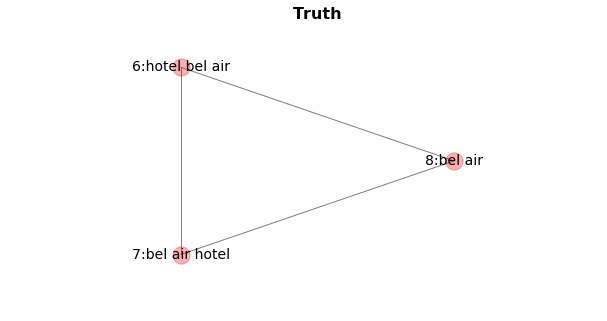

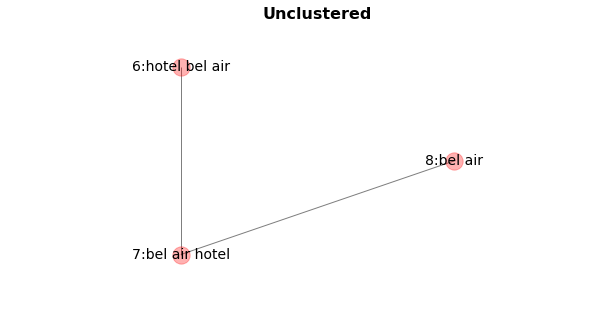

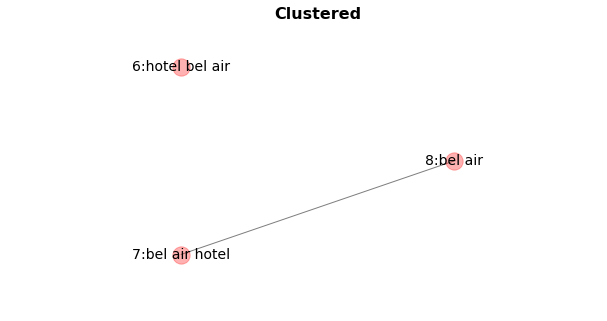

In [77]:
bad_diff_all_ids = {6, 7, 8}
show_cluster_graphs(
    df,
    golden_pairs_set, dedupe_found_pairs_set, dedupe_unclustered_found_pairs_set,
    bad_diff_all_ids)

Remember the `recall_weight` parameter of the `deduper.threshold` method? That's what it controls: how aggressive we want to be on finding or dropping matches while clustering. Check Dedupe docs for more details on how it [performs clustering](https://docs.dedupe.io/en/latest/Grouping-duplicates.html) and how it finds [a good threshold](https://docs.dedupe.io/en/latest/Choosing-a-good-threshold.html#).

Finally, it's worth mentioning there's a web-based [product version of Dedupe](https://dedupe.io/). If you don't want to write code for deduping a dataset, check it.

<center><img src="https://dedupe.io/images/tutorials/getting-started-with-dedupe-io/img-5.jpg" width=800></center>

## Next Steps

Once we have the clusters, how to consolidate data from many records into one? Check for material on **Data Fusion**:
  - [Open issue at Python Record Linkage Toolkit](https://github.com/J535D165/recordlinkage/issues/27)
  - Christen, 6.12 Merging Matches [2]

What if new records arrive? Should we merge, unmerge, move records from clusters? Check for material on **Incremental Record Linkage**:
  - Dedupe approach is to either add to an existing cluster or to create a new cluster. You can use a [Gazetteer](https://docs.dedupe.io/en/latest/API-documentation.html#gazetteer-objects) with previously deduped data, then merge new matches into it and index new nonmatches
  - Other approaches:
      * [Online Correlation Clustering](https://arxiv.org/pdf/1001.0920.pdf)
      * [Incremental Record Linkage](http://www.vldb.org/pvldb/vol7/p697-gruenheid.pdf)
      * [Heuristic-based approaches for speeding up incremental record linkage](https://www.sciencedirect.com/science/article/pii/S0164121217302972)

## References

- **Referenced by this talk**:
    * [1] [Mike Mull, The Art and Science of Data Matching](https://www.youtube.com/watch?v=Y-nYEOgq3YE) (slides [here](https://github.com/mikemull/Notebooks/blob/master/PyDataNYCSlides.ipynb))
    * [2] [Peter Christen, Data Matching](http://www.springer.com/us/book/9783642311635)
    * [3] [Mikhail Yuryevich Bilenko, Learnable Similarity Functions and Their Application to Record Linkage and Clustering](http://www.cs.utexas.edu/~ml/papers/marlin-dissertation-06.pdf)
- Other **talks** about Record Linkage with Python:
    * [Andrew Rowe, Big Data Deduplication and data matching using Python](https://www.youtube.com/watch?v=Z6mlvrYEYnk)
    * [Rhydwyn Mcguire, Record linkage: Join for real life](https://www.youtube.com/watch?v=cEcVIjyHfiQ)
- [Basics of Entity Resolution with Python and Dedupe](https://medium.com/district-data-labs/basics-of-entity-resolution-with-python-and-dedupe-bc87440b64d4)
- [Automating your Data Cleanup with Python](https://blog.kjamistan.com/automating-your-data-cleanup-with-python/)
- [Comparison of Data Matching software](https://github.com/J535D165/data-matching-software)
- [Compilation of Record Linkage resources](https://github.com/ropeladder/record-linkage-resources)

# Thank you!
flavio@vinta.com.br  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  
[vinta.com.br](https://www.vinta.com.br)

Special thanks to Russell Keith-Magee [@freakboy3742](https://twitter.com/freakboy3742) and Forest Timothy Gregg [@forestgregg](https://twitter.com/forestgregg) for reviewing this talk materials.